<a href="https://colab.research.google.com/github/Bo-Ni/ProteinDiffusionGenerator_Colab/blob/main/ProteinDiffusionGenerator_Model_B_inference_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model B: Protein Generator Diffusion model conditioned on residue-level secondary structure content

### Generative method to design novel proteins using a diffusion model 

B. Ni, D.L. Kaplan, M.J. Buehler, Generative design of de novo proteins based on secondary structure constraints using an attention-based diffusion model, Chem, 2023


In [1]:
#@title 1. Prepare the environment
import os,sys
import math

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #turn off CUDA if needed
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

path_1 = '/opt/bin/'
dssp_file = path_1+'mkdssp'

file_exists = os.path.exists(dssp_file)
if not (file_exists):
  print('\033[1;32m For the 1st run, ')
  # ==============================================
  print('a. Install omegafold...')
  # install omegafold
  # ref: https://github.com/HeliXonProtein/OmegaFold
  !pip install git+https://github.com/HeliXonProtein/OmegaFold.git

  # time-consuming step:
  # Downloading weights from https://helixon.s3.amazonaws.com/release1.pt to /root/.cache/omegafold_ckpt/model.pt
  !mkdir /root/.cache/omegafold_ckpt
  !wget https://helixon.s3.amazonaws.com/release1.pt -O /root/.cache/omegafold_ckpt/model.pt

  print('b. Install DSSP...')
  # download an mkdssp
  # ==============================================
  # download things
  print(os.popen(f"wget https://www.dropbox.com/s/v4azy9z9yojg1c6/mkdssp -P {path_1}").read())
  #
  !chmod u+x /opt/bin/mkdssp

else:
  print('This is not the first run... ')

 For the 1st run, 
a. Install omegafold...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/HeliXonProtein/OmegaFold.git to /tmp/pip-req-build-254dx1tr
  Running command git clone --filter=blob:none --quiet https://github.com/HeliXonProtein/OmegaFold.git /tmp/pip-req-build-254dx1tr
  Resolved https://github.com/HeliXonProtein/OmegaFold.git to commit 313c873ad190b64506a497c926649e15fcd88fcd
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 933.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.5 MB/s eta 0:00:00
  Created wheel for OmegaFold: filename=OmegaFold-0.0.0-py3-none-any.whl size=55681 sha256=eda4c9f1d265f2039cb21d74f2185a9f66bd264cd7b7065d9272981d1d2943e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-u1qpf_1m/wheels/07/8a/bc/571df5703a22cb5d07c8c494b47242a86bbf66372d65469517
Successfully built OmegaFold
  Attempting unin

In [2]:
#@title 2. Check libraries

# add some packages
try:
  print('\033[1;32m a. on Biopython...')
  from Bio.PDB import PDBParser
except ImportError as e:
  print(os.popen('pip install biopython').read())

try:
  print('\033[1;32m b. on kornia...')
  import kornia.augmentation
except ImportError as e:
  print(os.popen('pip install kornia').read())

try:
  print('\033[1;32m c. on einops...')
  from einops import rearrange, repeat, reduce
except ImportError as e:
  print(os.popen('pip install einops').read())  

try:
  from einops_exts import rearrange_many, repeat_many, check_shape
except ImportError as e:
  print(os.popen('pip install einops-exts').read())  

try:
  import pytorch_warmup as warmup
except ImportError as e:
  print(os.popen('pip install pytorch-warmup').read())    

try:
  from ema_pytorch import EMA
except ImportError as e:
  print(os.popen('pip install ema-pytorch').read())   

try:
  from accelerate import Accelerator, DistributedType, DistributedDataParallelKwargs
except ImportError as e:
  print(os.popen('pip install accelerate').read())      

try:
  import py3Dmol
except ImportError as e:
  print(os.popen('pip install py3Dmol').read()) 

 a. on Biopython...
 b. on kornia...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.1/628.1 kB 10.5 MB/s eta 0:00:00

 c. on einops...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.7 MB/s eta 0:00:00

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 5.5 MB/s eta 0:00:00

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



In [3]:
#@title 3. Prepare the model

from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP
from Bio.PDB import PDBList
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import torch
import shutil
from sklearn.model_selection import train_test_split
device = torch.device("cuda:0" if torch.cuda.is_available() 
                                  else "cpu")
# device
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
# available_gpus
num_of_gpus = torch.cuda.device_count()
print('# of GPUs: ', num_of_gpus)
# !nvidia-smi
from torch.utils.data import DataLoader,Dataset
import pandas as pd
import seaborn as sns
import torchvision
 
import matplotlib.pyplot as plt
import numpy as np
 
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from functools import partial, wraps
print("Torch version:", torch.__version__) 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler

from matplotlib.ticker import MaxNLocator
def params (model):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    pytorch_total_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print ("Total model parameters: ", pytorch_total_params," trainable parameters: ", pytorch_total_params_trainable)
### Data loader/dataset generator
class RegressionDataset(Dataset):

        def __init__(self, X_data, y_data):
            self.X_data = X_data
            self.y_data = y_data

        def __getitem__(self, index):
            return self.X_data[index], self.y_data[index]

        def __len__ (self):
            return len(self.X_data)
#### Dataloader for protein data 
# Load dataset
ynormfac=21.
Xnormfac=9.
batch_size_=256
max_length = 128
number = 99999999999999999
min_length=0
# train_loader, train_loader_noshuffle, test_loader,tokenizer_y, tokenizer_X \
#         = load_data_set_SS_seq2seq (file_path='PROTEIN_Mar18_2022_SECSTR_ALL.csv', 
#                    min_length=0, max_length=max_length, batch_size_=batch_size_, output_dim=3,
#                   maxdata=number, remove_longer=True,   split=0.1,
#                                  )
# # print (len (train_loader))
# # the tokenizers are generated during dataloader
# print(tokenizer_X)
# print(tokenizer_y)

# # save the token if they don't exist
# import pickle
# tokenizer_data = [tokenizer_X, tokenizer_y]
# tokenizer_file = 'Model_B_tokenizers.dat'
# with open(tokenizer_file, "wb") as f:
#   pickle.dump(tokenizer_data, f)

import pickle
tokenizer_file = 'Model_B_tokenizers.dat'

# https://github.com/Bo-Ni/ProteinDiffusionGenerator_Colab/raw/main/Model_B_tokenizers.dat
file_exists = os.path.exists(tokenizer_file)
if not (file_exists):
  # download things
  print(os.popen("wget https://github.com/Bo-Ni/ProteinDiffusionGenerator_Colab/raw/main/Model_B_tokenizers.dat").read())

with open(tokenizer_file, "rb") as f:
 tokenizer_data_1 = pickle.load(f)
  # print(pickle.load(f))
# print(tokenizer_data_1[0])
tokenizer_X = tokenizer_data_1[0]
tokenizer_y = tokenizer_data_1[1]
### Build diffusion model
########################################################
## Attention-Diffusion model
########################################################

#based on: https://github.com/lucidrains/imagen-pytorch

import math
import copy
from random import random
from typing import List, Union
from tqdm.auto import tqdm
from functools import partial, wraps
from contextlib import contextmanager, nullcontext
from collections import namedtuple
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.nn.parallel import DistributedDataParallel
from torch import nn, einsum
from torch.cuda.amp import autocast
from torch.special import expm1
import torchvision.transforms as T

import kornia.augmentation as K

from einops import rearrange, repeat, reduce
from einops.layers.torch import Rearrange, Reduce
from einops_exts import rearrange_many, repeat_many, check_shape
from einops_exts.torch import EinopsToAndFrom

# helper functions

def exists(val):
    return val is not None

def identity(t, *args, **kwargs):
    return t

def first(arr, d = None):
    if len(arr) == 0:
        return d
    return arr[0]

def maybe(fn):
    @wraps(fn)
    def inner(x):
        if not exists(x):
            return x
        return fn(x)
    return inner

def once(fn):
    called = False
    @wraps(fn)
    def inner(x):
        nonlocal called
        if called:
            return
        called = True
        return fn(x)
    return inner

print_once = once(print)

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def cast_tuple(val, length = None):
    if isinstance(val, list):
        val = tuple(val)

    output = val if isinstance(val, tuple) else ((val,) * default(length, 1))

    if exists(length):
        assert len(output) == length

    return output

def is_float_dtype(dtype):
    return any([dtype == float_dtype for float_dtype in (torch.float64, torch.float32, torch.float16, torch.bfloat16)])

def cast_uint8_images_to_float(images):
    if not images.dtype == torch.uint8:
        return images
    return images / 255

def module_device(module):
    return next(module.parameters()).device

def zero_init_(m):
    nn.init.zeros_(m.weight)
    if exists(m.bias):
        nn.init.zeros_(m.bias)

def eval_decorator(fn):
    def inner(model, *args, **kwargs):
        was_training = model.training
        model.eval()
        out = fn(model, *args, **kwargs)
        model.train(was_training)
        return out
    return inner

def pad_tuple_to_length(t, length, fillvalue = None):
    remain_length = length - len(t)
    if remain_length <= 0:
        return t
    return (*t, *((fillvalue,) * remain_length))

# helper classes

class Identity(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

    def forward(self, x, *args, **kwargs):
        return x

# tensor helpers

def log(t, eps: float = 1e-12):
    return torch.log(t.clamp(min = eps))

def l2norm(t):
    return F.normalize(t, dim = -1)

def right_pad_dims_to(x, t):
    padding_dims = x.ndim - t.ndim
    if padding_dims <= 0:
        return t
    return t.view(*t.shape, *((1,) * padding_dims))

def masked_mean(t, *, dim, mask = None):
    if not exists(mask):
        return t.mean(dim = dim)

    denom = mask.sum(dim = dim, keepdim = True)
    mask = rearrange(mask, 'b n -> b n 1')
    masked_t = t.masked_fill(~mask, 0.)

    return masked_t.sum(dim = dim) / denom.clamp(min = 1e-5)
def resize_image_to(
    image,
    target_image_size,
    clamp_range = None
):
    orig_image_size = image.shape[-1]

    if orig_image_size == target_image_size:
        return image

    out = F.interpolate(image.float(), target_image_size, mode = 'linear', align_corners = True) 

    return out
def normalize_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_zero_to_one(normed_img):
    return (normed_img + 1) * 0.5

# classifier free guidance functions
def prob_mask_like(shape, prob, device):
    if prob == 1:
        return torch.ones(shape, device = device, dtype = torch.bool)
    elif prob == 0:
        return torch.zeros(shape, device = device, dtype = torch.bool)
    else:
        return torch.zeros(shape, device = device).float().uniform_(0, 1) < prob

# gaussian diffusion with continuous time helper functions and classes
# large part of this was thanks to @crowsonkb at https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/utils.py

@torch.jit.script
def beta_linear_log_snr(t):
    return -torch.log(expm1(1e-4 + 10 * (t ** 2)))

@torch.jit.script
def alpha_cosine_log_snr(t, s: float = 0.008):
    return -log((torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** -2) - 1, eps = 1e-5) # not sure if this accounts for beta being clipped to 0.999 in discrete version

def log_snr_to_alpha_sigma(log_snr):
    return torch.sqrt(torch.sigmoid(log_snr)), torch.sqrt(torch.sigmoid(-log_snr))

class GaussianDiffusionContinuousTimes(nn.Module):
    def __init__(self, *, noise_schedule, timesteps = 1000):
        super().__init__()

        if noise_schedule == "linear":
            self.log_snr = beta_linear_log_snr
        elif noise_schedule == "cosine":
            self.log_snr = alpha_cosine_log_snr
        else:
            raise ValueError(f'invalid noise schedule {noise_schedule}')

        self.num_timesteps = timesteps

    def get_times(self, batch_size, noise_level, *, device):
        return torch.full((batch_size,), noise_level, device = device, dtype = torch.float32)

    def sample_random_times(self, batch_size, max_thres = 0.999, *, device):
        return torch.zeros((batch_size,), device = device).float().uniform_(0, max_thres)

    def get_condition(self, times):
        return maybe(self.log_snr)(times)

    def get_sampling_timesteps(self, batch, *, device):
        times = torch.linspace(1., 0., self.num_timesteps + 1, device = device)
        times = repeat(times, 't -> b t', b = batch)
        times = torch.stack((times[:, :-1], times[:, 1:]), dim = 0)
        times = times.unbind(dim = -1)
        return times

    def q_posterior(self, x_start, x_t, t, *, t_next = None):
        t_next = default(t_next, lambda: (t - 1. / self.num_timesteps).clamp(min = 0.))

        """ https://openreview.net/attachment?id=2LdBqxc1Yv&name=supplementary_material """
        log_snr = self.log_snr(t)
        log_snr_next = self.log_snr(t_next)
        log_snr, log_snr_next = map(partial(right_pad_dims_to, x_t), (log_snr, log_snr_next))

        alpha, sigma = log_snr_to_alpha_sigma(log_snr)
        alpha_next, sigma_next = log_snr_to_alpha_sigma(log_snr_next)

        # c - as defined near eq 33
        c = -expm1(log_snr - log_snr_next)
        posterior_mean = alpha_next * (x_t * (1 - c) / alpha + c * x_start)

        # following (eq. 33)
        posterior_variance = (sigma_next ** 2) * c
        posterior_log_variance_clipped = log(posterior_variance, eps = 1e-20)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def q_sample(self, x_start, t, noise = None):
        dtype = x_start.dtype

        if isinstance(t, float):
            batch = x_start.shape[0]
            t = torch.full((batch,), t, device = x_start.device, dtype = dtype)

        noise = default(noise, lambda: torch.randn_like(x_start))
        log_snr = self.log_snr(t).type(dtype)
        log_snr_padded_dim = right_pad_dims_to(x_start, log_snr)
        alpha, sigma =  log_snr_to_alpha_sigma(log_snr_padded_dim)

        return alpha * x_start + sigma * noise, log_snr

    def q_sample_from_to(self, x_from, from_t, to_t, noise = None):
        shape, device, dtype = x_from.shape, x_from.device, x_from.dtype
        batch = shape[0]

        if isinstance(from_t, float):
            from_t = torch.full((batch,), from_t, device = device, dtype = dtype)

        if isinstance(to_t, float):
            to_t = torch.full((batch,), to_t, device = device, dtype = dtype)

        noise = default(noise, lambda: torch.randn_like(x_from))

        log_snr = self.log_snr(from_t)
        log_snr_padded_dim = right_pad_dims_to(x_from, log_snr)
        alpha, sigma =  log_snr_to_alpha_sigma(log_snr_padded_dim)

        log_snr_to = self.log_snr(to_t)
        log_snr_padded_dim_to = right_pad_dims_to(x_from, log_snr_to)
        alpha_to, sigma_to =  log_snr_to_alpha_sigma(log_snr_padded_dim_to)

        return x_from * (alpha_to / alpha) + noise * (sigma_to * alpha - sigma * alpha_to) / alpha

    def predict_start_from_noise(self, x_t, t, noise):
        log_snr = self.log_snr(t)
        log_snr = right_pad_dims_to(x_t, log_snr)
        alpha, sigma = log_snr_to_alpha_sigma(log_snr)
        return (x_t - sigma * noise) / alpha.clamp(min = 1e-8)

# norms and residuals

class LayerNorm(nn.Module):
    def __init__(self, feats, stable = False, dim = -1):
        super().__init__()
        self.stable = stable
        self.dim = dim

        self.g = nn.Parameter(torch.ones(feats, *((1,) * (-dim - 1))))

    def forward(self, x):
        dtype, dim = x.dtype, self.dim

        if self.stable:
            x = x / x.amax(dim = dim, keepdim = True).detach()

        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = dim, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = dim, keepdim = True)

        return (x - mean) * (var + eps).rsqrt().type(dtype) * self.g.type(dtype)

ChanLayerNorm = partial(LayerNorm, dim = -2)

class Always():
    def __init__(self, val):
        self.val = val

    def __call__(self, *args, **kwargs):
        return self.val

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class Parallel(nn.Module):
    def __init__(self, *fns):
        super().__init__()
        self.fns = nn.ModuleList(fns)

    def forward(self, x):
        outputs = [fn(x) for fn in self.fns]
        return sum(outputs)
# attention pooling

class PerceiverAttention(nn.Module):
    def __init__(
        self,
        *,
        dim,
        dim_head = 64,
        heads = 8,
        cosine_sim_attn = False
    ):
        super().__init__()
        self.scale = dim_head ** -0.5 if not cosine_sim_attn else 1
        self.cosine_sim_attn = cosine_sim_attn
        self.cosine_sim_scale = 16 if cosine_sim_attn else 1

        self.heads = heads
        inner_dim = dim_head * heads

        self.norm = nn.LayerNorm(dim)
        self.norm_latents = nn.LayerNorm(dim)

        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim, bias = False),
            nn.LayerNorm(dim)
        )

    def forward(self, x, latents, mask = None):
        x = self.norm(x)
        latents = self.norm_latents(latents)

        b, h = x.shape[0], self.heads

        q = self.to_q(latents)

        # the paper differs from Perceiver in which they also concat the key / values 
        # derived from the latents to be attended to
        kv_input = torch.cat((x, latents), dim = -2)
        k, v = self.to_kv(kv_input).chunk(2, dim = -1)

        q, k, v = rearrange_many((q, k, v), 'b n (h d) -> b h n d', h = h)

        q = q * self.scale

        # cosine sim attention

        if self.cosine_sim_attn:
            q, k = map(l2norm, (q, k))

        # similarities and masking

        sim = einsum('... i d, ... j d  -> ... i j', q, k) * self.cosine_sim_scale

        if exists(mask):
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = F.pad(mask, (0, latents.shape[-2]), value = True)
             
            mask = rearrange(mask, 'b j -> b 1 1 j')
            sim = sim.masked_fill(~mask, max_neg_value)

        # attention

        attn = sim.softmax(dim = -1, dtype = torch.float32)
        attn = attn.to(sim.dtype)

        out = einsum('... i j, ... j d -> ... i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)', h = h)
        return self.to_out(out)

class PerceiverResampler(nn.Module):
    def __init__(
        self,
        *,
        dim,
        depth,
        dim_head = 64,
        heads = 8,
        num_latents = 64,
        num_latents_mean_pooled = 4, # number of latents derived from mean pooled representation of the sequence
        max_seq_len = 512,
        ff_mult = 4,
        cosine_sim_attn = False
    ):
        super().__init__()
        self.pos_emb = nn.Embedding(max_seq_len, dim)

        self.latents = nn.Parameter(torch.randn(num_latents, dim))

        self.to_latents_from_mean_pooled_seq = None

        if num_latents_mean_pooled > 0:
            self.to_latents_from_mean_pooled_seq = nn.Sequential(
                LayerNorm(dim),
                nn.Linear(dim, dim * num_latents_mean_pooled),
                Rearrange('b (n d) -> b n d', n = num_latents_mean_pooled)
            )

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PerceiverAttention(dim = dim, dim_head = dim_head, heads = heads, cosine_sim_attn = cosine_sim_attn),
                FeedForward(dim = dim, mult = ff_mult)
            ]))

    def forward(self, x, mask = None):
        n, device = x.shape[1], x.device
        pos_emb = self.pos_emb(torch.arange(n, device = device))

        x_with_pos = x + pos_emb

        latents = repeat(self.latents, 'n d -> b n d', b = x.shape[0])

        if exists(self.to_latents_from_mean_pooled_seq):
            meanpooled_seq = masked_mean(x, dim = 1, mask = torch.ones(x.shape[:2], device = x.device, dtype = torch.bool))
            meanpooled_latents = self.to_latents_from_mean_pooled_seq(meanpooled_seq)
            latents = torch.cat((meanpooled_latents, latents), dim = -2)

        for attn, ff in self.layers:
            latents = attn(x_with_pos, latents, mask = mask) + latents
            latents = ff(latents) + latents

        return latents

# attention

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        *,
        dim_head = 64,
        heads = 8,
        context_dim = None,
        cosine_sim_attn = False
    ):
        super().__init__()
        self.scale = dim_head ** -0.5 if not cosine_sim_attn else 1.
        self.cosine_sim_attn = cosine_sim_attn
        self.cosine_sim_scale = 16 if cosine_sim_attn else 1

        self.heads = heads
        inner_dim = dim_head * heads

        self.norm = LayerNorm(dim)

        self.null_kv = nn.Parameter(torch.randn(2, dim_head))
        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(dim, dim_head * 2, bias = False)

        self.to_context = nn.Sequential(nn.LayerNorm(context_dim), nn.Linear(context_dim, dim_head * 2)) if exists(context_dim) else None

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim, bias = False),
            LayerNorm(dim)
        )

    def forward(self, x, context = None, mask = None, attn_bias = None):
        b, n, device = *x.shape[:2], x.device

        x = self.norm(x)

        q, k, v = (self.to_q(x), *self.to_kv(x).chunk(2, dim = -1))

        q = rearrange(q, 'b n (h d) -> b h n d', h = self.heads)
        q = q * self.scale

        # add null key / value for classifier free guidance in prior net

        nk, nv = repeat_many(self.null_kv.unbind(dim = -2), 'd -> b 1 d', b = b)
        k = torch.cat((nk, k), dim = -2)
        v = torch.cat((nv, v), dim = -2)

        # add text conditioning, if present

        if exists(context):
            assert exists(self.to_context)
            ck, cv = self.to_context(context).chunk(2, dim = -1)
            k = torch.cat((ck, k), dim = -2)
            v = torch.cat((cv, v), dim = -2)

        # cosine sim attention

        if self.cosine_sim_attn:
            q, k = map(l2norm, (q, k))

        # calculate query / key similarities

        sim = einsum('b h i d, b j d -> b h i j', q, k) * self.cosine_sim_scale

        # relative positional encoding (T5 style)

        if exists(attn_bias):
            sim = sim + attn_bias

        # masking

        max_neg_value = -torch.finfo(sim.dtype).max

        if exists(mask):
            mask = F.pad(mask, (1, 0), value = True)
            
            mask = rearrange(mask, 'b j -> b 1 j')
            sim = sim.masked_fill(~mask, max_neg_value)

        # attention

        attn = sim.softmax(dim = -1, dtype = torch.float32)
        attn = attn.to(sim.dtype)

        # aggregate values

        out = einsum('b h i j, b j d -> b h i d', attn, v)

        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

# decoder

def Upsample(dim, dim_out = None):
    dim_out = default(dim_out, dim)

    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv1d(dim, dim_out, 3, padding = 1)
    )

class PixelShuffleUpsample(nn.Module):
    """
    code shared by @MalumaDev at DALLE2-pytorch for addressing checkboard artifacts
    https://arxiv.org/ftp/arxiv/papers/1707/1707.02937.pdf
    """
    def __init__(self, dim, dim_out = None):
        super().__init__()
        dim_out = default(dim_out, dim)
        conv = nn.Conv1d(dim, dim_out * 4, 1)

        self.net = nn.Sequential(
            conv,
            nn.SiLU(),
            nn.PixelShuffle(2)
        )

        self.init_conv_(conv)

    def init_conv_(self, conv):
         
        o, i, h  = conv.weight.shape
        conv_weight = torch.empty(o // 4, i, h )
        nn.init.kaiming_uniform_(conv_weight)
        conv_weight = repeat(conv_weight, 'o ... -> (o 4) ...')

        conv.weight.data.copy_(conv_weight)
        nn.init.zeros_(conv.bias.data)

    def forward(self, x):
        return self.net(x)

def Downsample(dim, dim_out = None):
    # https://arxiv.org/abs/2208.03641 shows this is the most optimal way to downsample
    # named SP-conv in the paper, but basically a pixel unshuffle
    dim_out = default(dim_out, dim)
   
    return nn.Sequential(
         
        Rearrange('b c (h s1)  -> b (c s1) h', s1 = 2),
        nn.Conv1d(dim * 2, dim_out, 1)
    )

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device = x.device) * -emb)
        emb = rearrange(x, 'i -> i 1') * rearrange(emb, 'j -> 1 j')
        return torch.cat((emb.sin(), emb.cos()), dim = -1)

class LearnedSinusoidalPosEmb(nn.Module):
    """ following @crowsonkb 's lead with learned sinusoidal pos emb """
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim))

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered

class Block(nn.Module):
    def __init__(
        self,
        dim,
        dim_out,
        groups = 8,
        norm = True
    ):
        super().__init__()
        self.groupnorm = nn.GroupNorm(groups, dim) if norm else Identity()
        self.activation = nn.SiLU()
        self.project = nn.Conv1d(dim, dim_out, 3, padding = 1)

    def forward(self, x, scale_shift = None):
        x = self.groupnorm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.activation(x)
        return self.project(x)

class ResnetBlock(nn.Module):
    def __init__(
        self,
        dim,
        dim_out,
        *,
        cond_dim = None,
        time_cond_dim = None,
        groups = 8,
        linear_attn = False,
        use_gca = False,
        squeeze_excite = False,
        **attn_kwargs
    ):
        super().__init__()

        self.time_mlp = None

        if exists(time_cond_dim):
            self.time_mlp = nn.Sequential(
                nn.SiLU(),
                nn.Linear(time_cond_dim, dim_out * 2)
            )

        self.cross_attn = None

        if exists(cond_dim):
            attn_klass = CrossAttention if not linear_attn else LinearCrossAttention

            self.cross_attn = EinopsToAndFrom(
           
                'b c h ',
                'b h c',
                attn_klass(
                    dim = dim_out,
                    context_dim = cond_dim,
                    **attn_kwargs
                )
            )

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)

        self.gca = GlobalContext(dim_in = dim_out, dim_out = dim_out) if use_gca else Always(1)

        self.res_conv = nn.Conv1d(dim, dim_out, 1) if dim != dim_out else Identity()


    def forward(self, x, time_emb = None, cond = None):

        scale_shift = None
        if exists(self.time_mlp) and exists(time_emb):
            time_emb = self.time_mlp(time_emb)
            
            time_emb = rearrange(time_emb, 'b c -> b c 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x)

        if exists(self.cross_attn):
            assert exists(cond)
            h = self.cross_attn(h, context = cond) + h

        h = self.block2(h, scale_shift = scale_shift)

        h = h * self.gca(h)

        return h + self.res_conv(x)

class CrossAttention(nn.Module):
    def __init__(
        self,
        dim,
        *,
        context_dim = None,
        dim_head = 64,
        heads = 8,
        norm_context = False,
        cosine_sim_attn = False
    ):
        super().__init__()
        self.scale = dim_head ** -0.5 if not cosine_sim_attn else 1.
        self.cosine_sim_attn = cosine_sim_attn
        self.cosine_sim_scale = 16 if cosine_sim_attn else 1

        self.heads = heads
        inner_dim = dim_head * heads

        context_dim = default(context_dim, dim)

        self.norm = LayerNorm(dim)
        self.norm_context = LayerNorm(context_dim) if norm_context else Identity()

        self.null_kv = nn.Parameter(torch.randn(2, dim_head))
        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim, bias = False),
            LayerNorm(dim)
        )

    def forward(self, x, context, mask = None):
        b, n, device = *x.shape[:2], x.device

        x = self.norm(x)
        context = self.norm_context(context)

        q, k, v = (self.to_q(x), *self.to_kv(context).chunk(2, dim = -1))

        q, k, v = rearrange_many((q, k, v), 'b n (h d) -> b h n d', h = self.heads)

        # add null key / value for classifier free guidance in prior net

        nk, nv = repeat_many(self.null_kv.unbind(dim = -2), 'd -> b h 1 d', h = self.heads,  b = b)

        k = torch.cat((nk, k), dim = -2)
        v = torch.cat((nv, v), dim = -2)

        q = q * self.scale

        # cosine sim attention

        if self.cosine_sim_attn:
            q, k = map(l2norm, (q, k))

        # similarities

        sim = einsum('b h i d, b h j d -> b h i j', q, k) * self.cosine_sim_scale

        # masking

        max_neg_value = -torch.finfo(sim.dtype).max

        if exists(mask):
            mask = F.pad(mask, (1, 0), value = True)
          
            mask = rearrange(mask, 'b j -> b 1 j')
            sim = sim.masked_fill(~mask, max_neg_value)

        attn = sim.softmax(dim = -1, dtype = torch.float32)
        attn = attn.to(sim.dtype)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class LinearCrossAttention(CrossAttention):
    def forward(self, x, context, mask = None):
        b, n, device = *x.shape[:2], x.device

        x = self.norm(x)
        context = self.norm_context(context)

        q, k, v = (self.to_q(x), *self.to_kv(context).chunk(2, dim = -1))

        q, k, v = rearrange_many((q, k, v), 'b n (h d) -> (b h) n d', h = self.heads)

        # add null key / value for classifier free guidance in prior net

        nk, nv = repeat_many(self.null_kv.unbind(dim = -2), 'd -> (b h) 1 d', h = self.heads,  b = b)

        k = torch.cat((nk, k), dim = -2)
        v = torch.cat((nv, v), dim = -2)

        # masking

        max_neg_value = -torch.finfo(x.dtype).max

        if exists(mask):
            mask = F.pad(mask, (1, 0), value = True)
            mask = rearrange(mask, 'b n -> b n 1')
            k = k.masked_fill(~mask, max_neg_value)
            v = v.masked_fill(~mask, 0.)

        # linear attention

        q = q.softmax(dim = -1)
        k = k.softmax(dim = -2)

        q = q * self.scale

        context = einsum('b n d, b n e -> b d e', k, v)
        out = einsum('b n d, b d e -> b n e', q, context)
        out = rearrange(out, '(b h) n d -> b n (h d)', h = self.heads)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(
        self,
        dim,
        dim_head = 32,
        heads = 8,
        dropout = 0.05,
        context_dim = None,
        **kwargs
    ):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        inner_dim = dim_head * heads
        self.norm = ChanLayerNorm(dim)

        self.nonlin = nn.SiLU()

        self.to_q = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv1d(dim, inner_dim, 1, bias = False),
            nn.Conv1d(inner_dim, inner_dim, 3, bias = False, padding = 1, groups = inner_dim)
        )

        self.to_k = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv1d(dim, inner_dim, 1, bias = False),
            nn.Conv1d(inner_dim, inner_dim, 3, bias = False, padding = 1, groups = inner_dim)
        )

        self.to_v = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv1d(dim, inner_dim, 1, bias = False),
            nn.Conv1d(inner_dim, inner_dim, 3, bias = False, padding = 1, groups = inner_dim)
        )

        self.to_context = nn.Sequential(nn.LayerNorm(context_dim), nn.Linear(context_dim, inner_dim * 2, bias = False)) if exists(context_dim) else None

        self.to_out = nn.Sequential(
            nn.Conv1d(inner_dim, dim, 1, bias = False),
            ChanLayerNorm(dim)
        )

    def forward(self, fmap, context = None):
        h, x, y = self.heads, *fmap.shape[-2:]

        fmap = self.norm(fmap)
        q, k, v = map(lambda fn: fn(fmap), (self.to_q, self.to_k, self.to_v))
        q, k, v = rearrange_many((q, k, v), 'b (h c) x y -> (b h) (x y) c', h = h)

        if exists(context):
            assert exists(self.to_context)
            ck, cv = self.to_context(context).chunk(2, dim = -1)
            ck, cv = rearrange_many((ck, cv), 'b n (h d) -> (b h) n d', h = h)
            k = torch.cat((k, ck), dim = -2)
            v = torch.cat((v, cv), dim = -2)

        q = q.softmax(dim = -1)
        k = k.softmax(dim = -2)

        q = q * self.scale

        context = einsum('b n d, b n e -> b d e', k, v)
        out = einsum('b n d, b d e -> b n e', q, context)
        out = rearrange(out, '(b h) (x y) d -> b (h d) x y', h = h, x = x, y = y)

        out = self.nonlin(out)
        return self.to_out(out)

class GlobalContext(nn.Module):
    """ basically a superior form of squeeze-excitation that is attention-esque """

    def __init__(
        self,
        *,
        dim_in,
        dim_out
    ):
        super().__init__()
        self.to_k = nn.Conv1d(dim_in, 1, 1)
        hidden_dim = max(3, dim_out // 2)

        self.net = nn.Sequential(
            nn.Conv1d(dim_in, hidden_dim, 1),
            nn.SiLU(),
            nn.Conv1d(hidden_dim, dim_out, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        context = self.to_k(x)
        x, context = rearrange_many((x, context), 'b n ... -> b n (...)')
        out = einsum('b i n, b c n -> b c i', context.softmax(dim = -1), x)
        
        return self.net(out)

def FeedForward(dim, mult = 2):
    hidden_dim = int(dim * mult)
    return nn.Sequential(
        LayerNorm(dim),
        nn.Linear(dim, hidden_dim, bias = False),
        nn.GELU(),
        LayerNorm(hidden_dim),
        nn.Linear(hidden_dim, dim, bias = False)
    )

def ChanFeedForward(dim, mult = 2):  # in paper, it seems for self attention layers they did feedforwards with twice channel width
    hidden_dim = int(dim * mult)
    return nn.Sequential(
        ChanLayerNorm(dim),
        nn.Conv1d(dim, hidden_dim, 1, bias = False),
        nn.GELU(),
        ChanLayerNorm(hidden_dim),
        nn.Conv1d(hidden_dim, dim, 1, bias = False)
    )

class TransformerBlock(nn.Module):
    def __init__(
        self,
        dim,
        *,
        depth = 1,
        heads = 8,
        dim_head = 32,
        ff_mult = 2,
        context_dim = None,
        cosine_sim_attn = False
    ):
        super().__init__()
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                EinopsToAndFrom('b c h', 'b h c', Attention(dim = dim, heads = heads, dim_head = dim_head, context_dim = context_dim, cosine_sim_attn = cosine_sim_attn)),
                ChanFeedForward(dim = dim, mult = ff_mult)
            ]))

    def forward(self, x, context = None):
        for attn, ff in self.layers:
            x = attn(x, context = context) + x
            x = ff(x) + x
        return x

class LinearAttentionTransformerBlock(nn.Module):
    def __init__(
        self,
        dim,
        *,
        depth = 1,
        heads = 8,
        dim_head = 32,
        ff_mult = 2,
        context_dim = None,
        **kwargs
    ):
        super().__init__()
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                LinearAttention(dim = dim, heads = heads, dim_head = dim_head, context_dim = context_dim),
                ChanFeedForward(dim = dim, mult = ff_mult)
            ]))

    def forward(self, x, context = None):
        for attn, ff in self.layers:
            x = attn(x, context = context) + x
            x = ff(x) + x
        return x

class CrossEmbedLayer(nn.Module):
    def __init__(
        self,
        dim_in,
        kernel_sizes,
        dim_out = None,
        stride = 2
    ):
        super().__init__()
        assert all([*map(lambda t: (t % 2) == (stride % 2), kernel_sizes)])
        dim_out = default(dim_out, dim_in)

        kernel_sizes = sorted(kernel_sizes)
        num_scales = len(kernel_sizes)

        # calculate the dimension at each scale
        dim_scales = [int(dim_out / (2 ** i)) for i in range(1, num_scales)]
        dim_scales = [*dim_scales, dim_out - sum(dim_scales)]

        self.convs = nn.ModuleList([])
        for kernel, dim_scale in zip(kernel_sizes, dim_scales):
            self.convs.append(nn.Conv1d(dim_in, dim_scale, kernel, stride = stride, padding = (kernel - stride) // 2))

    def forward(self, x):
        fmaps = tuple(map(lambda conv: conv(x), self.convs))
        return torch.cat(fmaps, dim = 1)

class UpsampleCombiner(nn.Module):
    def __init__(
        self,
        dim,
        *,
        enabled = False,
        dim_ins = tuple(),
        dim_outs = tuple()
    ):
        super().__init__()
        dim_outs = cast_tuple(dim_outs, len(dim_ins))
        assert len(dim_ins) == len(dim_outs)

        self.enabled = enabled

        if not self.enabled:
            self.dim_out = dim
            return

        self.fmap_convs = nn.ModuleList([Block(dim_in, dim_out) for dim_in, dim_out in zip(dim_ins, dim_outs)])
        self.dim_out = dim + (sum(dim_outs) if len(dim_outs) > 0 else 0)

    def forward(self, x, fmaps = None):
        target_size = x.shape[-1]

        fmaps = default(fmaps, tuple())

        if not self.enabled or len(fmaps) == 0 or len(self.fmap_convs) == 0:
            return x

        fmaps = [resize_image_to(fmap, target_size) for fmap in fmaps]
        outs = [conv(fmap) for fmap, conv in zip(fmaps, self.fmap_convs)]
        return torch.cat((x, *outs), dim = 1)
########################################################
## 1D Unet 
########################################################
class OneD_Unet(nn.Module):
    def __init__(
        self,
        *,
        dim,
        image_embed_dim = 1024,
        text_embed_dim = 768,  
        num_resnet_blocks = 1,
        cond_dim = None,
        num_image_tokens = 4,
        num_time_tokens = 2,
        learned_sinu_pos_emb_dim = 16,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        cond_images_channels = 0,
        channels = 3,
        channels_out = None,
        attn_dim_head = 64,
        attn_heads = 8,
        ff_mult = 2.,
        lowres_cond = False,                # for cascading diffusion - https://cascaded-diffusion.github.io/
        layer_attns = True,
        layer_attns_depth = 1,
        layer_attns_add_text_cond = True,   # whether to condition the self-attention blocks with the text embeddings, as described in Appendix D.3.1
        attend_at_middle = True,            # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
        layer_cross_attns = True,
        use_linear_attn = False,
        use_linear_cross_attn = False,
        cond_on_text = True,
        max_text_len = 256,
        init_dim = None,
        resnet_groups = 8,
        init_conv_kernel_size = 7,          # kernel size of initial conv, if not using cross embed
        init_cross_embed = False,
        init_cross_embed_kernel_sizes = (3, 7, 15),
        cross_embed_downsample = False,
        cross_embed_downsample_kernel_sizes = (2, 4),
        attn_pool_text = True,
        attn_pool_num_latents = 32,
        dropout = 0.,
        memory_efficient = False,
        init_conv_to_final_conv_residual = False,
        use_global_context_attn = True,
        scale_skip_connection = True,
        final_resnet_block = True,
        final_conv_kernel_size = 3,
        cosine_sim_attn = False,
        self_cond = False,
        combine_upsample_fmaps = False,      # combine feature maps from all upsample blocks, used in unet squared successfully
        pixel_shuffle_upsample = False  ,      # may address checkboard artifacts
        beginning_and_final_conv_present = True , #TODO add cross-attn, doesnt work yet...whether or not to have final conv layer
           
    ):
        super().__init__()

        assert attn_heads > 1, 'you need to have more than 1 attention head, ideally at least 4 or 8'

        # save locals to take care of some hyperparameters for cascading DDPM

        self._locals = locals()
        self._locals.pop('self', None)
        self._locals.pop('__class__', None)

        # determine dimensions

        self.channels = channels
        self.channels_out = default(channels_out, channels)

        init_channels = channels * (1 + int(lowres_cond) + int(self_cond))
        init_dim = default(init_dim, dim)

        self.self_cond = self_cond

        # optional image conditioning

        self.has_cond_image = cond_images_channels > 0
        self.cond_images_channels = cond_images_channels

        init_channels += cond_images_channels
 

        self.beginning_and_final_conv_present=beginning_and_final_conv_present
        
      
        if self.beginning_and_final_conv_present:
             self.init_conv = CrossEmbedLayer(init_channels, dim_out = init_dim, 
                                         kernel_sizes = init_cross_embed_kernel_sizes, stride = 1) if init_cross_embed else nn.Conv1d(init_channels, init_dim, init_conv_kernel_size, padding = init_conv_kernel_size // 2)
              
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        # time conditioning

        cond_dim = default(cond_dim, dim)
        time_cond_dim = dim * 4 * (2 if lowres_cond else 1)

        # embedding time for log(snr) noise from continuous version

        sinu_pos_emb = LearnedSinusoidalPosEmb(learned_sinu_pos_emb_dim)
        sinu_pos_emb_input_dim = learned_sinu_pos_emb_dim + 1

        self.to_time_hiddens = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(sinu_pos_emb_input_dim, time_cond_dim),
            nn.SiLU()
        )

        self.to_time_cond = nn.Sequential(
            nn.Linear(time_cond_dim, time_cond_dim)
        )

        # project to time tokens as well as time hiddens

        self.to_time_tokens = nn.Sequential(
            nn.Linear(time_cond_dim, cond_dim * num_time_tokens),
            Rearrange('b (r d) -> b r d', r = num_time_tokens)
        )

        # low res aug noise conditioning

        self.lowres_cond = lowres_cond

        if lowres_cond:
            self.to_lowres_time_hiddens = nn.Sequential(
                LearnedSinusoidalPosEmb(learned_sinu_pos_emb_dim),
                nn.Linear(learned_sinu_pos_emb_dim + 1, time_cond_dim),
                nn.SiLU()
            )

            self.to_lowres_time_cond = nn.Sequential(
                nn.Linear(time_cond_dim, time_cond_dim)
            )

            self.to_lowres_time_tokens = nn.Sequential(
                nn.Linear(time_cond_dim, cond_dim * num_time_tokens),
                Rearrange('b (r d) -> b r d', r = num_time_tokens)
            )

        # normalizations

        self.norm_cond = nn.LayerNorm(cond_dim)

        # text encoding conditioning (optional)

        self.text_to_cond = None

        if cond_on_text: #only add linear lear if cond dim is not text emnd dim
            assert exists(text_embed_dim), 'text_embed_dim must be given to the unet if cond_on_text is True'
            if text_embed_dim != cond_dim:
                self.text_to_cond = nn.Linear(text_embed_dim, cond_dim)
                self.text_cond_linear=True
                
            else:
                print ("Text conditioning is equatl to cond_dim - no linear layer used")
                self.text_cond_linear=False
                
        # finer control over whether to condition on text encodings

        self.cond_on_text = cond_on_text

        # attention pooling

        self.attn_pool = PerceiverResampler(dim = cond_dim, depth = 2, 
                                            dim_head = attn_dim_head, heads = attn_heads, 
                                            num_latents = attn_pool_num_latents, 
                                            cosine_sim_attn = cosine_sim_attn) if attn_pool_text else None

        # for classifier free guidance

        self.max_text_len = max_text_len

        self.null_text_embed = nn.Parameter(torch.randn(1, max_text_len, cond_dim))
        self.null_text_hidden = nn.Parameter(torch.randn(1, time_cond_dim))

        # for non-attention based text conditioning at all points in the network where time is also conditioned

        self.to_text_non_attn_cond = None

        if cond_on_text:
            self.to_text_non_attn_cond = nn.Sequential(
                nn.LayerNorm(cond_dim),
                nn.Linear(cond_dim, time_cond_dim),
                nn.SiLU(),
                nn.Linear(time_cond_dim, time_cond_dim)
            )

        # attention related params

        attn_kwargs = dict(heads = attn_heads, dim_head = attn_dim_head, cosine_sim_attn = cosine_sim_attn)

        num_layers = len(in_out)

        # resnet block klass

        num_resnet_blocks = cast_tuple(num_resnet_blocks, num_layers)
        resnet_groups = cast_tuple(resnet_groups, num_layers)

        resnet_klass = partial(ResnetBlock, **attn_kwargs)

        layer_attns = cast_tuple(layer_attns, num_layers)
        layer_attns_depth = cast_tuple(layer_attns_depth, num_layers)
        layer_cross_attns = cast_tuple(layer_cross_attns, num_layers)

        use_linear_attn = cast_tuple(use_linear_attn, num_layers)
        use_linear_cross_attn = cast_tuple(use_linear_cross_attn, num_layers)

        assert all([layers == num_layers for layers in list(map(len, (resnet_groups, layer_attns, layer_cross_attns)))])

        # downsample klass

        downsample_klass = Downsample

        if cross_embed_downsample:
            downsample_klass = partial(CrossEmbedLayer, kernel_sizes = cross_embed_downsample_kernel_sizes)

        # initial resnet block (for memory efficient unet)

        self.init_resnet_block = resnet_klass(init_dim, init_dim, time_cond_dim = time_cond_dim, groups = resnet_groups[0], use_gca = use_global_context_attn) if memory_efficient else None

        # scale for resnet skip connections

        self.skip_connect_scale = 1. if not scale_skip_connection else (2 ** -0.5)

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        layer_params = [num_resnet_blocks, resnet_groups, layer_attns, layer_attns_depth, layer_cross_attns, use_linear_attn, use_linear_cross_attn]
        reversed_layer_params = list(map(reversed, layer_params))

        # downsampling layers

        skip_connect_dims = [] # keep track of skip connection dimensions

        for ind, ((dim_in, dim_out), layer_num_resnet_blocks, groups, layer_attn, layer_attn_depth, layer_cross_attn, layer_use_linear_attn, layer_use_linear_cross_attn) in enumerate(zip(in_out, *layer_params)):
            is_last = ind >= (num_resolutions - 1)

            layer_cond_dim = cond_dim if layer_cross_attn or layer_use_linear_cross_attn else None

            if layer_attn:
                transformer_block_klass = TransformerBlock
            elif layer_use_linear_attn:
                transformer_block_klass = LinearAttentionTransformerBlock
            else:
                transformer_block_klass = Identity

            current_dim = dim_in

            # whether to pre-downsample, from memory efficient unet

            pre_downsample = None

            if memory_efficient:
                pre_downsample = downsample_klass(dim_in, dim_out)
                current_dim = dim_out

            skip_connect_dims.append(current_dim)

            # whether to do post-downsample, for non-memory efficient unet

            post_downsample = None
            if not memory_efficient:
                post_downsample = downsample_klass(current_dim, dim_out) if not is_last else Parallel(nn.Conv1d(dim_in, dim_out, 3, padding = 1), nn.Conv1d(dim_in, dim_out, 1))

            self.downs.append(nn.ModuleList([
                pre_downsample,
                resnet_klass(current_dim, current_dim, cond_dim = layer_cond_dim, linear_attn = layer_use_linear_cross_attn, time_cond_dim = time_cond_dim, groups = groups),
                nn.ModuleList([ResnetBlock(current_dim, current_dim, time_cond_dim = time_cond_dim, groups = groups, use_gca = use_global_context_attn) for _ in range(layer_num_resnet_blocks)]),
                transformer_block_klass(dim = current_dim, depth = layer_attn_depth, ff_mult = ff_mult, context_dim = cond_dim, **attn_kwargs),
                post_downsample
            ]))

        # middle layers

        mid_dim = dims[-1]

        self.mid_block1 = ResnetBlock(mid_dim, mid_dim, cond_dim = cond_dim, time_cond_dim = time_cond_dim, groups = resnet_groups[-1])
        self.mid_attn = EinopsToAndFrom('b c h', 'b h c', Residual(Attention(mid_dim, **attn_kwargs))) if attend_at_middle else None
        self.mid_block2 = ResnetBlock(mid_dim, mid_dim, cond_dim = cond_dim, time_cond_dim = time_cond_dim, groups = resnet_groups[-1])

        # upsample klass

        upsample_klass = Upsample if not pixel_shuffle_upsample else PixelShuffleUpsample

        # upsampling layers

        upsample_fmap_dims = []

        for ind, ((dim_in, dim_out), layer_num_resnet_blocks, groups, layer_attn, layer_attn_depth, layer_cross_attn, layer_use_linear_attn, layer_use_linear_cross_attn) in enumerate(zip(reversed(in_out), *reversed_layer_params)):
            is_last = ind == (len(in_out) - 1)

            layer_cond_dim = cond_dim if layer_cross_attn or layer_use_linear_cross_attn else None

            if layer_attn:
                transformer_block_klass = TransformerBlock
            elif layer_use_linear_attn:
                transformer_block_klass = LinearAttentionTransformerBlock
            else:
                transformer_block_klass = Identity

            skip_connect_dim = skip_connect_dims.pop()

            upsample_fmap_dims.append(dim_out)

            self.ups.append(nn.ModuleList([
                resnet_klass(dim_out + skip_connect_dim, dim_out, cond_dim = layer_cond_dim, linear_attn = layer_use_linear_cross_attn, time_cond_dim = time_cond_dim, groups = groups),
                nn.ModuleList([ResnetBlock(dim_out + skip_connect_dim, dim_out, time_cond_dim = time_cond_dim, groups = groups, use_gca = use_global_context_attn) for _ in range(layer_num_resnet_blocks)]),
                transformer_block_klass(dim = dim_out, depth = layer_attn_depth, ff_mult = ff_mult, context_dim = cond_dim, **attn_kwargs),
                upsample_klass(dim_out, dim_in) if not is_last or memory_efficient else Identity()
            ]))

        # whether to combine feature maps from all upsample blocks before final resnet block out

        self.upsample_combiner = UpsampleCombiner(
            dim = dim,
            enabled = combine_upsample_fmaps,
            dim_ins = upsample_fmap_dims,
            dim_outs = dim
        )

        # whether to do a final residual from initial conv to the final resnet block out

        self.init_conv_to_final_conv_residual = init_conv_to_final_conv_residual
        final_conv_dim = self.upsample_combiner.dim_out + (dim if init_conv_to_final_conv_residual else 0)

        # final optional resnet block and convolution out

        self.final_res_block = ResnetBlock(final_conv_dim, dim, time_cond_dim = time_cond_dim, groups = resnet_groups[0], use_gca = True) if final_resnet_block else None

        final_conv_dim_in = dim if final_resnet_block else final_conv_dim
        final_conv_dim_in += (channels if lowres_cond else 0)

        if self.beginning_and_final_conv_present:
            print (final_conv_dim_in, self.channels_out)
            self.final_conv = nn.Conv1d(final_conv_dim_in, self.channels_out, final_conv_kernel_size, padding = final_conv_kernel_size // 2)

        if self.beginning_and_final_conv_present:
            zero_init_(self.final_conv)

    # if the current settings for the unet are not correct
    # for cascading DDPM, then reinit the unet with the right settings
    def cast_model_parameters(
        self,
        *,
        lowres_cond,
        text_embed_dim,
        channels,
        channels_out,
        cond_on_text
    ):
        if lowres_cond == self.lowres_cond and \
            channels == self.channels and \
            cond_on_text == self.cond_on_text and \
            text_embed_dim == self._locals['text_embed_dim'] and \
            channels_out == self.channels_out:
            return self

        updated_kwargs = dict(
            lowres_cond = lowres_cond,
            text_embed_dim = text_embed_dim,
            channels = channels,
            channels_out = channels_out,
            cond_on_text = cond_on_text
        )

        return self.__class__(**{**self._locals, **updated_kwargs})

    # methods for returning the full unet config as well as its parameter state

    def to_config_and_state_dict(self):
        return self._locals, self.state_dict()

    # class method for rehydrating the unet from its config and state dict

    @classmethod
    def from_config_and_state_dict(klass, config, state_dict):
        unet = klass(**config)
        unet.load_state_dict(state_dict)
        return unet

    # methods for persisting unet to disk

    def persist_to_file(self, path):
        path = Path(path)
        path.parents[0].mkdir(exist_ok = True, parents = True)

        config, state_dict = self.to_config_and_state_dict()
        pkg = dict(config = config, state_dict = state_dict)
        torch.save(pkg, str(path))

    # class method for rehydrating the unet from file saved with `persist_to_file`

    @classmethod
    def hydrate_from_file(klass, path):
        path = Path(path)
        assert path.exists()
        pkg = torch.load(str(path))

        assert 'config' in pkg and 'state_dict' in pkg
        config, state_dict = pkg['config'], pkg['state_dict']

        return Unet.from_config_and_state_dict(config, state_dict)

    # forward with classifier free guidance

    def forward_with_cond_scale(
        self,
        *args,
        cond_scale = 1.,
        **kwargs
    ):
        logits = self.forward(*args, **kwargs)

        if cond_scale == 1:
            return logits

        null_logits = self.forward(*args, cond_drop_prob = 1., **kwargs)
        return null_logits + (logits - null_logits) * cond_scale

    def forward(
        self,
        x,
        time,
        *,
        lowres_cond_img = None,
        lowres_noise_times = None,
        text_embeds = None,
        text_mask = None,
        cond_images = None,
        self_cond = None,
        cond_drop_prob = 0.
    ):
        batch_size, device = x.shape[0], x.device
         # condition on self

        if self.self_cond:
            self_cond = default(self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x, self_cond), dim = 1)

        # add low resolution conditioning, if present

        assert not (self.lowres_cond and not exists(lowres_cond_img)), 'low resolution conditioning image must be present'
        assert not (self.lowres_cond and not exists(lowres_noise_times)), 'low resolution conditioning noise time must be present'

        if exists(lowres_cond_img):
            x = torch.cat((x, lowres_cond_img), dim = 1)

        # condition on input image

        assert not (self.has_cond_image ^ exists(cond_images)), 'you either requested to condition on an image on the unet, but the conditioning image is not supplied, or vice versa'

        if exists(cond_images):
            assert cond_images.shape[1] == self.cond_images_channels, 'the number of channels on the conditioning image you are passing in does not match what you specified on initialiation of the unet'
            cond_images = resize_image_to(cond_images, x.shape[-1])
            
            x = torch.cat((cond_images.to(device), x.to(device)), dim = 1)

        # initial convolution
      
        if self.beginning_and_final_conv_present:
            x = self.init_conv(x)  

        # init conv residual

        if self.init_conv_to_final_conv_residual:
            init_conv_residual = x.clone()

        # time conditioning

        time_hiddens = self.to_time_hiddens(time)

        # derive time tokens

        time_tokens = self.to_time_tokens(time_hiddens)
        t = self.to_time_cond(time_hiddens)

        # add lowres time conditioning to time hiddens
        # and add lowres time tokens along sequence dimension for attention

        if self.lowres_cond:
            lowres_time_hiddens = self.to_lowres_time_hiddens(lowres_noise_times)
            lowres_time_tokens = self.to_lowres_time_tokens(lowres_time_hiddens)
            lowres_t = self.to_lowres_time_cond(lowres_time_hiddens)

            t = t + lowres_t
            
            time_tokens = torch.cat((time_tokens, lowres_time_tokens), dim = -2)

        # text conditioning

        text_tokens = None

        if exists(text_embeds) and self.cond_on_text:

            # conditional dropout

            text_keep_mask = prob_mask_like((batch_size,), 1 - cond_drop_prob, device = device)
            
            text_keep_mask_embed = rearrange(text_keep_mask, 'b -> b 1 1')
            text_keep_mask_hidden = rearrange(text_keep_mask, 'b -> b 1')

            # calculate text embeds
             
            if self.text_cond_linear:
                text_tokens = self.text_to_cond(text_embeds)
            else:
                text_tokens=text_embeds

            text_tokens = text_tokens[:, :self.max_text_len]
            
            if exists(text_mask):
                text_mask = text_mask[:, :self.max_text_len]

            text_tokens_len = text_tokens.shape[1]
            remainder = self.max_text_len - text_tokens_len
             
            if remainder > 0:
                 
                text_tokens = F.pad(text_tokens, (0, 0, 0, remainder))

            if exists(text_mask):
                if remainder > 0:
                    text_mask = F.pad(text_mask, (0, remainder), value = False)

                
                text_mask = rearrange(text_mask, 'b n -> b n 1')
                text_keep_mask_embed = text_mask & text_keep_mask_embed
            
            null_text_embed = self.null_text_embed.to(text_tokens.dtype) # for some reason pytorch AMP not working
            text_tokens = torch.where(
                text_keep_mask_embed,
                text_tokens,
                null_text_embed
            )
            
            if exists(self.attn_pool):
                text_tokens = self.attn_pool(text_tokens)

            # extra non-attention conditioning by projecting and then summing text embeddings to time
            # termed as text hiddens
            
            mean_pooled_text_tokens = text_tokens.mean(dim = -2)

            text_hiddens = self.to_text_non_attn_cond(mean_pooled_text_tokens)

            null_text_hidden = self.null_text_hidden.to(t.dtype)

            text_hiddens = torch.where(
                text_keep_mask_hidden,
                text_hiddens,
                null_text_hidden
            )

            t = t + text_hiddens

        # main conditioning tokens (c)
        
        c = time_tokens if not exists(text_tokens) else torch.cat((time_tokens, text_tokens), dim = -2)
        
        # normalize conditioning tokens

        c = self.norm_cond(c)
        
        # initial resnet block (for memory efficient unet)

        if exists(self.init_resnet_block):
            x = self.init_resnet_block(x, t)
        
        # go through the layers of the unet, down and up

        hiddens = []

        for pre_downsample, init_block, resnet_blocks, attn_block, post_downsample in self.downs:
            if exists(pre_downsample):
                x = pre_downsample(x)
            
            x = init_block(x, t, c)
             
            for resnet_block in resnet_blocks:
                x = resnet_block(x, t)
                hiddens.append(x)
            
            
            x = attn_block(x, c)
            
            hiddens.append(x)

            if exists(post_downsample):
                
                x = post_downsample(x)

        x = self.mid_block1(x, t, c)
        
        if exists(self.mid_attn):
            x = self.mid_attn(x)

        x = self.mid_block2(x, t, c)
        
        add_skip_connection = lambda x: torch.cat((x, hiddens.pop() * self.skip_connect_scale), dim = 1)

        up_hiddens = []
        
        for init_block, resnet_blocks, attn_block, upsample in self.ups:
            x = add_skip_connection(x)
            x = init_block(x, t, c)
            
            for resnet_block in resnet_blocks:
                x = add_skip_connection(x)
                x = resnet_block(x, t)

            x = attn_block(x, c)
            up_hiddens.append(x.contiguous())
            x = upsample(x)

        # whether to combine all feature maps from upsample blocks

        x = self.upsample_combiner(x, up_hiddens)

        # final top-most residual if needed

        if self.init_conv_to_final_conv_residual:
            x = torch.cat((x, init_conv_residual), dim = 1)

        if exists(self.final_res_block):
            x = self.final_res_block(x, t)

        if exists(lowres_cond_img):
            x = torch.cat((x, lowres_cond_img), dim = 1)
            
        if self.beginning_and_final_conv_present:
            x=self.final_conv(x) 
       
        return x
########################################################
## null unets 
########################################################

class NullUnet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.lowres_cond = False
        self.dummy_parameter = nn.Parameter(torch.tensor([0.]))

    def cast_model_parameters(self, *args, **kwargs):
        return self

    def forward(self, x, *args, **kwargs):
        return x
    
class Unet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.lowres_cond = False
        self.dummy_parameter = nn.Parameter(torch.tensor([0.]))

    def cast_model_parameters(self, *args, **kwargs):
        return self

    def forward(self, x, *args, **kwargs):
        return x

########################################################
## Elucidated denoising model 
## After: Tero Karras and Miika Aittala and Timo Aila and Samuli Laine, 
##        Elucidating the Design Space of Diffusion-Based Generative Models
##        https://arxiv.org/abs/2206.00364, 2022
########################################################

from math import sqrt

Hparams_fields = [
    'num_sample_steps',
    'sigma_min',
    'sigma_max',
    'sigma_data',
    'rho',
    'P_mean',
    'P_std',
    'S_churn',
    'S_tmin',
    'S_tmax',
    'S_noise'
]

Hparams = namedtuple('Hparams', Hparams_fields)

# helper functions

def log(t, eps = 1e-20):
    return torch.log(t.clamp(min = eps))

# main class

class ElucidatedImagen(nn.Module):
    def __init__(
        self,
        unets,
        *,
        image_sizes,                                # for cascading ddpm, image size at each stage
        text_encoder_name = '',
        text_embed_dim = None,
        channels = 3,
        channels_out=3,
        cond_drop_prob = 0.1,
        random_crop_sizes = None,
        lowres_sample_noise_level = 0.2,            # in the paper, they present a new trick where they noise the lowres conditioning image, and at sample time, fix it to a certain level (0.1 or 0.3) - the unets are also made to be conditioned on this noise level
        per_sample_random_aug_noise_level = False,  # unclear when conditioning on augmentation noise level, whether each batch element receives a random aug noise value - turning off due to @marunine's find
        condition_on_text = True,
        auto_normalize_img = True,                  # whether to take care of normalizing the image from [0, 1] to [-1, 1] and back automatically - you can turn this off if you want to pass in the [-1, 1] ranged image yourself from the dataloader
        dynamic_thresholding = True,
        dynamic_thresholding_percentile = 0.95,     # unsure what this was based on perusal of paper
        only_train_unet_number = None,
        lowres_noise_schedule = 'linear',
        num_sample_steps = 32,                      # number of sampling steps
        sigma_min = 0.002,                          # min noise level
        sigma_max = 80,                             # max noise level
        sigma_data = 0.5,                           # standard deviation of data distribution
        rho = 7,                                    # controls the sampling schedule
        P_mean = -1.2,                              # mean of log-normal distribution from which noise is drawn for training
        P_std = 1.2,                                # standard deviation of log-normal distribution from which noise is drawn for training
        S_churn = 80,                               # parameters for stochastic sampling - depends on dataset, Table 5 in apper
        S_tmin = 0.05,
        S_tmax = 50,
        S_noise = 1.003,
        
        loss_type=0, #0=MSE,  
        categorical_loss_ignore=None,
    ):
        super().__init__()

        self.only_train_unet_number = only_train_unet_number

        self.condition_on_text = condition_on_text
        self.unconditional = not condition_on_text
        self.loss_type=loss_type
        if self.loss_type>0:
            self.categorical_loss=True
            self.m = nn.LogSoftmax(dim=1) #used for some loss functins
        else:
            self.categorical_loss=False
            
        
        self.categorical_loss_ignore=categorical_loss_ignore
        
        # channels

        self.channels = channels
        self.channels_out = channels_out

        unets = cast_tuple(unets)
        num_unets = len(unets)

        # randomly cropping for upsampler training

        self.random_crop_sizes = cast_tuple(random_crop_sizes, num_unets)
        assert not exists(first(self.random_crop_sizes)), 'you should not need to randomly crop image during training for base unet, only for upsamplers - so pass in `random_crop_sizes = (None, 128, 256)` as example'

        # lowres augmentation noise schedule

        self.lowres_noise_schedule = GaussianDiffusionContinuousTimes(noise_schedule = lowres_noise_schedule)

        # get text encoder

        self.text_embed_dim =text_embed_dim
    
        # construct unets

        self.unets = nn.ModuleList([])
        self.unet_being_trained_index = -1 # keeps track of which unet is being trained at the moment

        print (f"Channels in={self.channels}, channels out={self.channels_out}")
        for ind, one_unet in enumerate(unets):
             
            assert isinstance(one_unet, ( OneD_Unet, NullUnet))
            is_first = ind == 0

            one_unet = one_unet.cast_model_parameters(
                lowres_cond = not is_first,
                cond_on_text = self.condition_on_text,
                text_embed_dim = self.text_embed_dim if self.condition_on_text else None,
                channels = self.channels,
                #channels_out = self.channels
                channels_out = self.channels_out
            )

            self.unets.append(one_unet)

        # determine whether we are training on images or video

        is_video = False # 
        self.is_video = is_video

        self.right_pad_dims_to_datatype = partial(rearrange, pattern = ('b -> b 1 1' if not is_video else 'b -> b 1 1 1'))
        self.resize_to = resize_video_to if is_video else resize_image_to

        
        self.image_sizes = image_sizes
        assert num_unets == len(self.image_sizes), f'you did not supply the correct number of u-nets ({len(self.unets)}) for resolutions {self.image_sizes}'

        self.sample_channels = cast_tuple(self.channels, num_unets)

        lowres_conditions = tuple(map(lambda t: t.lowres_cond, self.unets))
        assert lowres_conditions == (False, *((True,) * (num_unets - 1))), 'the first unet must be unconditioned (by low resolution image), and the rest of the unets must have `lowres_cond` set to True'

        self.lowres_sample_noise_level = lowres_sample_noise_level
        self.per_sample_random_aug_noise_level = per_sample_random_aug_noise_level

        # classifier free guidance

        self.cond_drop_prob = cond_drop_prob
        self.can_classifier_guidance = cond_drop_prob > 0.

        # normalize and unnormalize image functions

        self.normalize_img = normalize_neg_one_to_one if auto_normalize_img else identity
        self.unnormalize_img = unnormalize_zero_to_one if auto_normalize_img else identity
        self.input_image_range = (0. if auto_normalize_img else -1., 1.)

        # dynamic thresholding

        self.dynamic_thresholding = cast_tuple(dynamic_thresholding, num_unets)
        self.dynamic_thresholding_percentile = dynamic_thresholding_percentile

        # elucidating parameters

        hparams = [
            num_sample_steps,
            sigma_min,
            sigma_max,
            sigma_data,
            rho,
            P_mean,
            P_std,
            S_churn,
            S_tmin,
            S_tmax,
            S_noise,
        ]

        hparams = [cast_tuple(hp, num_unets) for hp in hparams]
        self.hparams = [Hparams(*unet_hp) for unet_hp in zip(*hparams)]

        # one temp parameter for keeping track of device

        self.register_buffer('_temp', torch.tensor([0.]).to(device), persistent = False)

        # default to device of unets passed in

        self.to(next(self.unets.parameters()).device)
        
        print ("Device used in ImagenEluc: ", self.device)

    def force_unconditional_(self):
        self.condition_on_text = False
        self.unconditional = True

        for unet in self.unets:
            unet.cond_on_text = False

    @property
    def device(self):
        #return self._temp.device
        return (device)

    def get_unet(self, unet_number):
        assert 0 < unet_number <= len(self.unets)
        index = unet_number - 1

        if isinstance(self.unets, nn.ModuleList):
            unets_list = [unet for unet in self.unets]
            delattr(self, 'unets')
            self.unets = unets_list

        if index != self.unet_being_trained_index:
            for unet_index, unet in enumerate(self.unets):
                unet.to(self.device if unet_index == index else 'cpu')

        self.unet_being_trained_index = index
        return self.unets[index]

    def reset_unets_all_one_device(self, device = None):
        device = default(device, self.device)
        
        self.unets = nn.ModuleList([*self.unets])
        self.unets.to(device)

        self.unet_being_trained_index = -1

    @contextmanager
    def one_unet_in_gpu(self, unet_number = None, unet = None):
        assert exists(unet_number) ^ exists(unet)

        if exists(unet_number):
            unet = self.unets[unet_number - 1]

        devices = [module_device(unet) for unet in self.unets]
        self.unets.cpu()
        unet.to(self.device)
        
        yield

        for unet, device in zip(self.unets, devices):
            unet.to(device)

    # overriding state dict functions

    def state_dict(self, *args, **kwargs):
        self.reset_unets_all_one_device()
        return super().state_dict(*args, **kwargs)

    def load_state_dict(self, *args, **kwargs):
        self.reset_unets_all_one_device()
        return super().load_state_dict(*args, **kwargs)

    # dynamic thresholding

    def threshold_x_start(self, x_start, dynamic_threshold = True):
        if not dynamic_threshold:
            return x_start.clamp(-1., 1.)

        s = torch.quantile(
            rearrange(x_start, 'b ... -> b (...)').abs(),
            self.dynamic_thresholding_percentile,
            dim = -1
        )

        s.clamp_(min = 1.)
        s = right_pad_dims_to(x_start, s)
        return x_start.clamp(-s, s) / s

    # derived preconditioning params - Table 1

    def c_skip(self, sigma_data, sigma):
        return (sigma_data ** 2) / (sigma ** 2 + sigma_data ** 2)

    def c_out(self, sigma_data, sigma):
        return sigma * sigma_data * (sigma_data ** 2 + sigma ** 2) ** -0.5

    def c_in(self, sigma_data, sigma):
        return 1 * (sigma ** 2 + sigma_data ** 2) ** -0.5

    def c_noise(self, sigma):
        return log(sigma) * 0.25

   # preconditioned network output
    # equation (7) in the paper

    def preconditioned_network_forward(
        self,
        unet_forward,
        noised_images,
        sigma,
        *,
        sigma_data,
        clamp = False,
        dynamic_threshold = True,
        **kwargs
    ):
        batch, device = noised_images.shape[0], noised_images.device
        
        if isinstance(sigma, float):
            sigma = torch.full((batch,), sigma, device = device)

        padded_sigma = self.right_pad_dims_to_datatype(sigma)

        net_out = unet_forward(
            self.c_in(sigma_data, padded_sigma) * noised_images,
            self.c_noise(sigma),
            **kwargs
        )

        out = self.c_skip(sigma_data, padded_sigma) * noised_images +  self.c_out(sigma_data, padded_sigma) * net_out

        if not clamp:
            return out

        return self.threshold_x_start(out, dynamic_threshold)

    # sampling

    # sample schedule
    # equation (5) in the paper

    def sample_schedule(
        self,
        num_sample_steps,
        rho,
        sigma_min,
        sigma_max
    ):
        N = num_sample_steps
        inv_rho = 1 / rho

        steps = torch.arange(num_sample_steps, device = self.device, dtype = torch.float32)
        sigmas = (sigma_max ** inv_rho + steps / (N - 1) * (sigma_min ** inv_rho - sigma_max ** inv_rho)) ** rho

        sigmas = F.pad(sigmas, (0, 1), value = 0.) # last step is sigma value of 0.
        return sigmas

    @torch.no_grad()
    def one_unet_sample(
        self,
        unet,
        shape,
        *,
        unet_number,
        clamp = True,
        dynamic_threshold = True,
        cond_scale = 1.,
        use_tqdm = True,
        inpaint_images = None,
        inpaint_masks = None,
        inpaint_resample_times = 5,
        init_images = None,
        skip_steps = None,
        sigma_min = None,
        sigma_max = None,
        **kwargs
    ):
        # get specific sampling hyperparameters for unet

        hp = self.hparams[unet_number - 1]

        sigma_min = default(sigma_min, hp.sigma_min)
        sigma_max = default(sigma_max, hp.sigma_max)

        # get the schedule, which is returned as (sigma, gamma) tuple, and pair up with the next sigma and gamma

        sigmas = self.sample_schedule(hp.num_sample_steps, hp.rho, sigma_min, sigma_max)

        gammas = torch.where(
            (sigmas >= hp.S_tmin) & (sigmas <= hp.S_tmax),
            min(hp.S_churn / hp.num_sample_steps, sqrt(2) - 1),
            0.
        )

        sigmas_and_gammas = list(zip(sigmas[:-1], sigmas[1:], gammas[:-1]))

        # images is noise at the beginning

        init_sigma = sigmas[0]

        images = init_sigma * torch.randn(shape, device = self.device)

        # initializing with an image

        if exists(init_images):
            images += init_images

        # keeping track of x0, for self conditioning if needed

        x_start = None

        # prepare inpainting images and mask

        has_inpainting = exists(inpaint_images) and exists(inpaint_masks)
        resample_times = inpaint_resample_times if has_inpainting else 1

        if has_inpainting:
            inpaint_images = self.normalize_img(inpaint_images)
            inpaint_images = self.resize_to(inpaint_images, shape[-1])
            inpaint_masks = self.resize_to(rearrange(inpaint_masks, 'b ... -> b 1 ...').float(), shape[-1]).bool()

        # unet kwargs

        unet_kwargs = dict(
            sigma_data = hp.sigma_data,
            clamp = clamp,
            dynamic_threshold = dynamic_threshold,
            cond_scale = cond_scale,
            **kwargs
        )

        # gradually denoise

        initial_step = default(skip_steps, 0)
        sigmas_and_gammas = sigmas_and_gammas[initial_step:]

        total_steps = len(sigmas_and_gammas)

        for ind, (sigma, sigma_next, gamma) in tqdm(enumerate(sigmas_and_gammas), total = total_steps, desc = 'sampling time step', disable = not use_tqdm):
            is_last_timestep = ind == (total_steps - 1)

            sigma, sigma_next, gamma = map(lambda t: t.item(), (sigma, sigma_next, gamma))

            for r in reversed(range(resample_times)):
                is_last_resample_step = r == 0

                eps = hp.S_noise * torch.randn(shape, device = self.device) # stochastic sampling

                sigma_hat = sigma + gamma * sigma
                added_noise = sqrt(sigma_hat ** 2 - sigma ** 2) * eps

                images_hat = images + added_noise

                self_cond = x_start if unet.self_cond else None

                if has_inpainting:
                    images_hat = images_hat * ~inpaint_masks + (inpaint_images + added_noise) * inpaint_masks

                model_output = self.preconditioned_network_forward(
                    unet.forward_with_cond_scale,
                    images_hat,
                    sigma_hat,
                    self_cond = self_cond,
                    **unet_kwargs
                )
                
                denoised_over_sigma = (images_hat - model_output) / sigma_hat

                images_next = images_hat + (sigma_next - sigma_hat) * denoised_over_sigma

                # second order correction, if not the last timestep

                if sigma_next != 0:
                    self_cond = model_output if unet.self_cond else None

                    model_output_next = self.preconditioned_network_forward(
                        unet.forward_with_cond_scale,
                        images_next,
                        sigma_next,
                        self_cond = self_cond,
                        **unet_kwargs
                    )
                  
                    denoised_prime_over_sigma = (images_next - model_output_next) / sigma_next
                    images_next = images_hat + 0.5 * (sigma_next - sigma_hat) * (denoised_over_sigma + denoised_prime_over_sigma)

                images = images_next

                if has_inpainting and not (is_last_resample_step or is_last_timestep):
                    # renoise in repaint and then resample
                    repaint_noise = torch.randn(shape, device = self.device)
                    images = images + (sigma - sigma_next) * repaint_noise

                x_start = model_output  # save model output for self conditioning
            

        if has_inpainting:
            images = images * ~inpaint_masks + inpaint_images * inpaint_masks

        return  images

    @torch.no_grad()
    @eval_decorator
    def sample(
        self,
        texts: List[str] = None,
        text_masks = None,
        text_embeds = None,
        cond_images = None,
        inpaint_images = None,
        inpaint_masks = None,
        inpaint_resample_times = 5,
        init_images = None,
        skip_steps = None,
        sigma_min = None,
        sigma_max = None,
        video_frames = None,
        batch_size = 1,
        cond_scale = 1.,
        lowres_sample_noise_level = None,
        start_at_unet_number = 1,
        start_image_or_video = None,
        stop_at_unet_number = None,
        return_all_unet_outputs = False,
        return_pil_images = False,
        use_tqdm = True,
        device = None,
        
    ):

        self.reset_unets_all_one_device(device = device)

        cond_images = maybe(cast_uint8_images_to_float)(cond_images)

        if exists(texts) and not exists(text_embeds) and not self.unconditional:
            assert all([*map(len, texts)]), 'text cannot be empty'

            with autocast(enabled = False):
                text_embeds, text_masks = self.encode_text(texts, return_attn_mask = True)

            text_embeds, text_masks = map(lambda t: t.to(device), (text_embeds, text_masks))

        if not self.unconditional:
            assert exists(text_embeds), 'text must be passed in if the network was not trained without text `condition_on_text` must be set to `False` when training'

            text_masks = default(text_masks, lambda: torch.any(text_embeds != 0., dim = -1))
            batch_size = text_embeds.shape[0]

        if exists(inpaint_images):
            if self.unconditional:
                if batch_size == 1: # assume researcher wants to broadcast along inpainted images
                    batch_size = inpaint_images.shape[0]

            assert inpaint_images.shape[0] == batch_size, 'number of inpainting images must be equal to the specified batch size on sample `sample(batch_size=<int>)``'
            assert not (self.condition_on_text and inpaint_images.shape[0] != text_embeds.shape[0]), 'number of inpainting images must be equal to the number of text to be conditioned on'

        assert not (self.condition_on_text and not exists(text_embeds)), 'text or text encodings must be passed into imagen if specified'
        assert not (not self.condition_on_text and exists(text_embeds)), 'imagen specified not to be conditioned on text, yet it is presented'
        assert not (exists(text_embeds) and text_embeds.shape[-1] != self.text_embed_dim), f'invalid text embedding dimension being passed in (should be {self.text_embed_dim})'

        assert not (exists(inpaint_images) ^ exists(inpaint_masks)),  'inpaint images and masks must be both passed in to do inpainting'

        outputs = []

        is_cuda = next(self.parameters()).is_cuda
        device = next(self.parameters()).device

        lowres_sample_noise_level = default(lowres_sample_noise_level, self.lowres_sample_noise_level)

        num_unets = len(self.unets)
        cond_scale = cast_tuple(cond_scale, num_unets)

        # handle video and frame dimension

        assert not (self.is_video and not exists(video_frames)), 'video_frames must be passed in on sample time if training on video'

        frame_dims = (video_frames,) if self.is_video else tuple()

        # initializing with an image or video

        init_images = cast_tuple(init_images, num_unets)
        init_images = [maybe(self.normalize_img)(init_image) for init_image in init_images]

        skip_steps = cast_tuple(skip_steps, num_unets)

        sigma_min = cast_tuple(sigma_min, num_unets)
        sigma_max = cast_tuple(sigma_max, num_unets)

        # handle starting at a unet greater than 1, for training only-upscaler training

        if start_at_unet_number > 1:
            assert start_at_unet_number <= num_unets, 'must start a unet that is less than the total number of unets'
            assert not exists(stop_at_unet_number) or start_at_unet_number <= stop_at_unet_number
            assert exists(start_image_or_video), 'starting image or video must be supplied if only doing upscaling'

            prev_image_size = self.image_sizes[start_at_unet_number - 2]
            img = self.resize_to(start_image_or_video, prev_image_size)

  
        for unet_number, unet, channel, image_size, unet_hparam, dynamic_threshold, unet_cond_scale, unet_init_images, unet_skip_steps, unet_sigma_min, unet_sigma_max in tqdm(zip(range(1, num_unets + 1), self.unets, self.sample_channels, self.image_sizes, self.hparams, self.dynamic_thresholding, cond_scale, init_images, skip_steps, sigma_min, sigma_max), disable = not use_tqdm):
            if unet_number < start_at_unet_number:
                continue

            assert not isinstance(unet, NullUnet), 'cannot sample from null unet'

            context = self.one_unet_in_gpu(unet = unet) if is_cuda else nullcontext()

            with context:
                lowres_cond_img = lowres_noise_times = None

                shape = (batch_size, channel, *frame_dims, image_size )

                if unet.lowres_cond:
                    lowres_noise_times = self.lowres_noise_schedule.get_times(batch_size, lowres_sample_noise_level, device = device)

                    lowres_cond_img = self.resize_to(img, image_size)
                    
                   
                    lowres_cond_img = self.normalize_img(lowres_cond_img.float())

                    lowres_cond_img, _ = self.lowres_noise_schedule.q_sample(x_start = lowres_cond_img.float(), 
                                                                             t = lowres_noise_times, 
                                                                             noise = torch.randn_like(lowres_cond_img.float()))

                if exists(unet_init_images):
                    unet_init_images = self.resize_to(unet_init_images, image_size)

                 
                shape = (batch_size, self.channels, *frame_dims, image_size)

                img = self.one_unet_sample(
                    unet,
                    shape,
                    unet_number = unet_number,
                    text_embeds = text_embeds,
                    text_mask =text_masks,
                    cond_images = cond_images,
                    inpaint_images = inpaint_images,
                    inpaint_masks = inpaint_masks,
                    inpaint_resample_times = inpaint_resample_times,
                    init_images = unet_init_images,
                    skip_steps = unet_skip_steps,
                    sigma_min = unet_sigma_min,
                    sigma_max = unet_sigma_max,
                    cond_scale = unet_cond_scale,
                    lowres_cond_img = lowres_cond_img,
                    lowres_noise_times = lowres_noise_times,
                    dynamic_threshold = dynamic_threshold,
                    use_tqdm = use_tqdm
                )
               
                if self.categorical_loss:
                    img=self.m(img)
                outputs.append(img)

            if exists(stop_at_unet_number) and stop_at_unet_number == unet_number:
                break

        output_index = -1 if not return_all_unet_outputs else slice(None) # either return last unet output or all unet outputs


        if not return_all_unet_outputs:
            outputs = outputs[-1:]

        assert not self.is_video, 'automatically converting video tensor to video file for saving is not built yet'
        
        if self.categorical_loss:
            return  torch.argmax(outputs[output_index], dim=1).unsqueeze (1)
        else:
            return  outputs[output_index]

    # training

    def loss_weight(self, sigma_data, sigma):
        return (sigma ** 2 + sigma_data ** 2) * (sigma * sigma_data) ** -2

    def noise_distribution(self, P_mean, P_std, batch_size):
        return (P_mean + P_std * torch.randn((batch_size,), device = self.device)).exp()

    def forward(
        self,
        images,
        unet: Union[  NullUnet, DistributedDataParallel] = None,
        texts: List[str] = None,
        text_embeds = None,
        text_masks = None,
        unet_number = None,
        cond_images = None,
         
    ):
        assert not (len(self.unets) > 1 and not exists(unet_number)), f'you must specify which unet you want trained, from a range of 1 to {len(self.unets)}, if you are training cascading DDPM (multiple unets)'
        unet_number = default(unet_number, 1)
        assert not exists(self.only_train_unet_number) or self.only_train_unet_number == unet_number, 'you can only train on unet #{self.only_train_unet_number}'

       
        cond_images = maybe(cast_uint8_images_to_float)(cond_images)
       
        if self.categorical_loss==False:
            assert is_float_dtype(images.dtype), f'images tensor needs to be floats but {images.dtype} dtype found instead'

        unet_index = unet_number - 1
        
        unet = default(unet, lambda: self.get_unet(unet_number))

        assert not isinstance(unet, NullUnet), 'null unet cannot and should not be trained'

        target_image_size    = self.image_sizes[unet_index]
        random_crop_size     = self.random_crop_sizes[unet_index]
        prev_image_size      = self.image_sizes[unet_index - 1] if unet_index > 0 else None
        hp                   = self.hparams[unet_index]

        
        batch_size, c, *_, h, device, is_video = *images.shape, images.device, (images.ndim == 4)

        frames = images.shape[2] if is_video else None

        check_shape(images, 'b c ...', c = self.channels)

        
        assert h >= target_image_size

        if exists(texts) and not exists(text_embeds) and not self.unconditional:
            assert all([*map(len, texts)]), 'text cannot be empty'
            assert len(texts) == len(images), 'number of text captions does not match up with the number of images given'

            with autocast(enabled = False):
                text_embeds, text_masks = self.encode_text(texts, return_attn_mask = True)

            text_embeds, text_masks = map(lambda t: t.to(images.device), (text_embeds, text_masks))

        if not self.unconditional:
            text_masks = default(text_masks, lambda: torch.any(text_embeds != 0., dim = -1))

        assert not (self.condition_on_text and not exists(text_embeds)), 'text or text encodings must be passed into decoder if specified'
        assert not (not self.condition_on_text and exists(text_embeds)), 'decoder specified not to be conditioned on text, yet it is presented'

        assert not (exists(text_embeds) and text_embeds.shape[-1] != self.text_embed_dim), f'invalid text embedding dimension being passed in (should be {self.text_embed_dim})'

        lowres_cond_img = lowres_aug_times = None
        if exists(prev_image_size):
            lowres_cond_img = self.resize_to(images, prev_image_size, clamp_range = self.input_image_range)
            lowres_cond_img = self.resize_to(lowres_cond_img, target_image_size, clamp_range = self.input_image_range)

            if self.per_sample_random_aug_noise_level:
                lowres_aug_times = self.lowres_noise_schedule.sample_random_times(batch_size, device = device)
            else:
                lowres_aug_time = self.lowres_noise_schedule.sample_random_times(1, device = device)
                lowres_aug_times = repeat(lowres_aug_time, '1 -> b', b = batch_size)

        if exists(random_crop_size):
            aug = K.RandomCrop((random_crop_size, random_crop_size), p = 1.)

            if is_video:
                images, lowres_cond_img = rearrange_many((images, lowres_cond_img), 'b c f h -> (b f) c h')

            images = aug(images)
            lowres_cond_img = aug(lowres_cond_img, params = aug._params)

            if is_video:
                images, lowres_cond_img = rearrange_many((images, lowres_cond_img), '(b f) c h -> b c f h', f = frames)

      
        lowres_cond_img_noisy = None
        if exists(lowres_cond_img):
            lowres_cond_img_noisy, _ = self.lowres_noise_schedule.q_sample(x_start = lowres_cond_img, 
                                                                           t = lowres_aug_times,
                                                                           noise = torch.randn_like(lowres_cond_img.float()))

        # get the sigmas

        sigmas = self.noise_distribution(hp.P_mean, hp.P_std, batch_size).to(device)
        padded_sigmas = self.right_pad_dims_to_datatype(sigmas).to(device)

        # noise

        noise = torch.randn_like(images.float()).to(device)
        
       
        noised_images = images + padded_sigmas * noise  # alphas are 1. in the paper
     
        # unet kwargs

        unet_kwargs = dict(
            sigma_data = hp.sigma_data,
            text_embeds = text_embeds,
            text_mask =text_masks,
            cond_images = cond_images,
            lowres_noise_times = self.lowres_noise_schedule.get_condition(lowres_aug_times),
            lowres_cond_img = lowres_cond_img_noisy,
            cond_drop_prob = self.cond_drop_prob,
        )

        # self conditioning - https://arxiv.org/abs/2208.04202 - training will be 25% slower

        # Because 'unet' can be an instance of DistributedDataParallel coming from the
        # ImagenTrainer.unet_being_trained when invoking ImagenTrainer.forward(), we need to
        # access the member 'module' of the wrapped unet instance.
        
        self_cond = unet.module.self_cond if isinstance(unet, DistributedDataParallel) else unet

        if self_cond and random() < 0.5:
            with torch.no_grad():
                pred_x0 = self.preconditioned_network_forward(
                    unet.forward,
                    noised_images,
                    sigmas,
                    **unet_kwargs
                ).detach()

            unet_kwargs = {**unet_kwargs, 'self_cond': pred_x0}

        # get prediction

        denoised_images = self.preconditioned_network_forward(
            unet.forward,
            noised_images,
            sigmas,
            **unet_kwargs
        )

        # losses
        
        if self.loss_type==0: 

            losses = F.mse_loss(denoised_images, images, reduction = 'none')
            losses = reduce(losses, 'b ... -> b', 'mean')

            # loss weighting

            losses = losses * self.loss_weight(hp.sigma_data, sigmas)
            losses=losses.mean()

        return losses 
## Define protein generative diffusion model - Model B
class ProteinDesigner_B(nn.Module):
    def __init__(self, unet, timesteps=10 , dim=32,pred_dim=25,loss_type=0, 
                 elucidated=True ,  
                  padding_idx=0,
                cond_dim = 512,
                text_embed_dim = 512,
                 input_tokens=25,#for non-BERT
                 sequence_embed=False,
                 embed_dim_position=32,
                 max_text_len=16,
                 cond_images_channels=0,
                
                ):
        super(ProteinDesigner_B, self).__init__()

        print ("Model B: Generative protein diffusion model, residue-based")
        self.pred_dim=pred_dim
        self.loss_type=loss_type
        
        assert loss_type == 0, "Losses other than MSE not implemented"
        
        self.fc_embed1 = nn.Linear( 8,  max_length)      # not used
        self.fc_embed2 = nn.Linear( 1,  text_embed_dim)  #
        self.max_text_len=max_text_len
       
        self.pos_emb_x = nn.Embedding(max_text_len+1, embed_dim_position)
        text_embed_dim=text_embed_dim+embed_dim_position
        
        self.pos_matrix_i = torch.zeros (max_text_len, dtype=torch.long)
        for i in range (max_text_len):
            self.pos_matrix_i [i]=i +1         

        condition_on_text=True        
        self.cond_images_channels=cond_images_channels 
        
        if self.cond_images_channels>0:
            condition_on_text = False 
            
        if self.cond_images_channels>0:
            print ("Use conditioning image during training....")
        
        assert elucidated , "Only elucidated model implemented...."
        self.is_elucidated=elucidated
        if elucidated:
            self.imagen = ElucidatedImagen(
                unets = (unet),
                channels=self.pred_dim,
                channels_out=self.pred_dim ,
                loss_type=loss_type, 
                condition_on_text = condition_on_text,
                text_embed_dim = text_embed_dim,
                image_sizes = ( [max_length ]),
                cond_drop_prob = 0.1,
                auto_normalize_img = False, 
                num_sample_steps = timesteps, # number of sample steps - 64 for base unet, 32 for upsampler (just an example, have no clue what the optimal values are)
                sigma_min = 0.002,           # min noise level
                sigma_max = 160,#(80, 160),       # max noise level, @crowsonkb recommends double the max noise level for upsampler
                sigma_data = 0.5,            # standard deviation of data distribution
                rho = 7,                     # controls the sampling schedule
                P_mean = -1.2,               # mean of log-normal distribution from which noise is drawn for training
                P_std = 1.2,                 # standard deviation of log-normal distribution from which noise is drawn for training
                S_churn = 40,#80,                # parameters for stochastic sampling - depends on dataset, Table 5 in apper
                S_tmin = 0.05,
                S_tmax = 50,
                S_noise = 1.003,
                 
                    ).to(device)
        else:
             print ("Not implemented.")
            
    def forward(self,output,  x=None, cond_images = None, 
                unet_number=1,
               ): 
       
        if x !=None:
            x_in=torch.zeros( (x.shape[0],max_length) ).to(device)
            x_in[:,:x.shape[1]]=x
            x=x_in       
            
            x=x.unsqueeze (2)
           
            x= self.fc_embed2(x)
            
            pos_matrix_i_=self.pos_matrix_i.repeat(x.shape[0], 1).to(device) 
            pos_emb_x = self.pos_emb_x( pos_matrix_i_)
            pos_emb_x = torch.squeeze(pos_emb_x, 1)

            x= torch.cat( (x,   pos_emb_x ), 2)        
        
        loss =  self.imagen(output, text_embeds = x,  cond_images=cond_images.to(device), 
                            unet_number = unet_number, )
 
        return loss
    
    def sample (self, x=None, stop_at_unet_number=1 ,cond_scale=7.5, 
                x_data=None, skip_steps=None,
                     inpaint_images = None,
                    inpaint_masks = None,
                    inpaint_resample_times = 5,
                    init_images = None,
                x_data_tokenized=None,device=None,
                   ):
           
        batch_size=1
        
        if x_data != None:
            print ("Conditioning target sequence provided via x_data ...", x_data)
            x_data = tokenizer_X.texts_to_sequences(x_data)
            x_data= sequence.pad_sequences(x_data,  maxlen=max_length, padding='post', truncating='post')
            
            x_data= torch.from_numpy(x_data).float().to(device)
            x_data = x_data/Xnormfac
            x_data=x_data.unsqueeze (2)
            x_data=torch.permute(x_data, (0,2,1)  )
            
            print ("x_data from target sequence=", x_data, x_data.shape)
            batch_size=x_data.shape[0]
            
        if x_data_tokenized != None:
            print ("Conditioning target sequence provided via x_data_tokenized ...", x_data_tokenized, x_data_tokenized.shape)
             
            x_data=x_data_tokenized.unsqueeze (2)
            x_data=torch.permute(x_data, (0,2,1)  ).to(device)
            print ("Data provided from x_data_tokenized: ", x_data.shape)
            batch_size=x_data.shape[0]
            
        if init_images != None:
            print ("Init sequence provided...", init_images)
            init_images = tokenizer_y.texts_to_sequences(init_images)
            init_images= sequence.pad_sequences(init_images,  maxlen=max_length, padding='post', truncating='post')
            init_images= torch.from_numpy(init_images).float().to(device)/ynormfac
            print ("init_images=", init_images)   
            
        if inpaint_images != None:
            print ("Inpaint sequence provided...", inpaint_images)
            print ("Mask:                            ", inpaint_masks)
            inpaint_images = tokenizer_y.texts_to_sequences(inpaint_images)
            inpaint_images= sequence.pad_sequences(inpaint_images,  maxlen=max_length, padding='post', truncating='post')
            inpaint_images= torch.from_numpy(inpaint_images).float().to(device)/ynormfac
            print ("in_paint images=", inpaint_images)   
                      
        if x !=None:
            x_in=torch.zeros( (x.shape[0],max_length) ).to(device)
            x_in[:,:x.shape[1]]=x
            x=x_in
            x=x.unsqueeze (2)
          
            x= self.fc_embed2(x)
            
            pos_matrix_i_=self.pos_matrix_i.repeat(x.shape[0], 1).to(device) 
            pos_emb_x = self.pos_emb_x( pos_matrix_i_)
            pos_emb_x = torch.squeeze(pos_emb_x, 1)
            
            x= torch.cat( (x,   pos_emb_x ), 2)    
            
            batch_size=x.shape[0]
    
        output =  self.imagen.sample(text_embeds= x, cond_scale = cond_scale, 
                                     stop_at_unet_number=stop_at_unet_number,
                                    cond_images=x_data,
                                     skip_steps=skip_steps,
                                     inpaint_images = inpaint_images,
                                        inpaint_masks = inpaint_masks,
                                        inpaint_resample_times = inpaint_resample_times,
                                        init_images = init_images,batch_size=batch_size,
                                     device=device,
                                    )
       
        return output 
## Training loop
import os
import time
import copy
from pathlib import Path
from math import ceil
from contextlib import contextmanager, nullcontext
from functools import partial, wraps
from collections.abc import Iterable

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR
from torch.cuda.amp import autocast, GradScaler

import pytorch_warmup as warmup
 
from packaging import version
__version__ = '1.9.3'

def cycle(dl):
    while True:
        for data in dl:
            yield data
            
from packaging import version

import numpy as np

from ema_pytorch import EMA

from accelerate import Accelerator, DistributedType, DistributedDataParallelKwargs

from fsspec.core import url_to_fs
from fsspec.implementations.local import LocalFileSystem

# helper functions

def exists(val):
    return val is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def cast_tuple(val, length = 1):
    if isinstance(val, list):
        val = tuple(val)
    
    return val if isinstance(val, tuple) else ((val,) * length)

def find_first(fn, arr):
    for ind, el in enumerate(arr):
        if fn(el):
            return ind
    return -1

def pick_and_pop(keys, d):
    values = list(map(lambda key: d.pop(key), keys))
    return dict(zip(keys, values))

def group_dict_by_key(cond, d):
    return_val = [dict(),dict()]
    for key in d.keys():
        match = bool(cond(key))
        ind = int(not match)
        return_val[ind][key] = d[key]
    return (*return_val,)

def string_begins_with(prefix, str):
    return str.startswith(prefix)

def group_by_key_prefix(prefix, d):
    return group_dict_by_key(partial(string_begins_with, prefix), d)

def groupby_prefix_and_trim(prefix, d):
    kwargs_with_prefix, kwargs = group_dict_by_key(partial(string_begins_with, prefix), d)
    kwargs_without_prefix = dict(map(lambda x: (x[0][len(prefix):], x[1]), tuple(kwargs_with_prefix.items())))
    return kwargs_without_prefix, kwargs

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

# url to fs, bucket, path - for checkpointing to cloud

def url_to_bucket(url):
    if '://' not in url:
        return url

    _, suffix = url.split('://')

    if prefix in {'gs', 's3'}:
        return suffix.split('/')[0]
    else:
        raise ValueError(f'storage type prefix "{prefix}" is not supported yet')

# decorators

def eval_decorator(fn):
    def inner(model, *args, **kwargs):
        was_training = model.training
        model.eval()
        out = fn(model, *args, **kwargs)
        model.train(was_training)
        return out
    return inner

def cast_torch_tensor(fn, cast_fp16 = False):
    @wraps(fn)
    def inner(model, *args, **kwargs):
        device = kwargs.pop('_device', model.device)
        cast_device = kwargs.pop('_cast_device', True)

        should_cast_fp16 = cast_fp16 and model.cast_half_at_training

        kwargs_keys = kwargs.keys()
        all_args = (*args, *kwargs.values())
        split_kwargs_index = len(all_args) - len(kwargs_keys)
        all_args = tuple(map(lambda t: torch.from_numpy(t) if exists(t) and isinstance(t, np.ndarray) else t, all_args))

        if cast_device:
            all_args = tuple(map(lambda t: t.to(device) if exists(t) and isinstance(t, torch.Tensor) else t, all_args))

        if should_cast_fp16:
            all_args = tuple(map(lambda t: t.half() if exists(t) and isinstance(t, torch.Tensor) and t.dtype != torch.bool else t, all_args))

        args, kwargs_values = all_args[:split_kwargs_index], all_args[split_kwargs_index:]
        kwargs = dict(tuple(zip(kwargs_keys, kwargs_values)))

        out = fn(model, *args, **kwargs)
        return out
    return inner

# gradient accumulation functions

def split_iterable(it, split_size):
    accum = []
    for ind in range(ceil(len(it) / split_size)):
        start_index = ind * split_size
        accum.append(it[start_index: (start_index + split_size)])
    return accum

def split(t, split_size = None):
    if not exists(split_size):
        return t

    if isinstance(t, torch.Tensor):
        return t.split(split_size, dim = 0)

    if isinstance(t, Iterable):
        return split_iterable(t, split_size)

    return TypeError

def find_first(cond, arr):
    for el in arr:
        if cond(el):
            return el
    return None

def split_args_and_kwargs(*args, split_size = None, **kwargs):
    all_args = (*args, *kwargs.values())
    len_all_args = len(all_args)
    first_tensor = find_first(lambda t: isinstance(t, torch.Tensor), all_args)
    assert exists(first_tensor)

    batch_size = len(first_tensor)
    split_size = default(split_size, batch_size)
    num_chunks = ceil(batch_size / split_size)

    dict_len = len(kwargs)
    dict_keys = kwargs.keys()
    split_kwargs_index = len_all_args - dict_len

    split_all_args = [split(arg, split_size = split_size) if exists(arg) and isinstance(arg, (torch.Tensor, Iterable)) else ((arg,) * num_chunks) for arg in all_args]
    chunk_sizes = tuple(map(len, split_all_args[0]))

    for (chunk_size, *chunked_all_args) in tuple(zip(chunk_sizes, *split_all_args)):
        chunked_args, chunked_kwargs_values = chunked_all_args[:split_kwargs_index], chunked_all_args[split_kwargs_index:]
        chunked_kwargs = dict(tuple(zip(dict_keys, chunked_kwargs_values)))
        chunk_size_frac = chunk_size / batch_size
        yield chunk_size_frac, (chunked_args, chunked_kwargs)

# imagen trainer

def imagen_sample_in_chunks(fn):
    @wraps(fn)
    def inner(self, *args, max_batch_size = None, **kwargs):
        if not exists(max_batch_size):
            return fn(self, *args, **kwargs)

        if self.imagen.unconditional:
            batch_size = kwargs.get('batch_size')
            batch_sizes = num_to_groups(batch_size, max_batch_size)
            outputs = [fn(self, *args, **{**kwargs, 'batch_size': sub_batch_size}) for sub_batch_size in batch_sizes]
        else:
            outputs = [fn(self, *chunked_args, **chunked_kwargs) for _, (chunked_args, chunked_kwargs) in split_args_and_kwargs(*args, split_size = max_batch_size, **kwargs)]

        if isinstance(outputs[0], torch.Tensor):
            return torch.cat(outputs, dim = 0)

        return list(map(lambda t: torch.cat(t, dim = 0), list(zip(*outputs))))

    return inner


def restore_parts(state_dict_target, state_dict_from):
    for name, param in state_dict_from.items():

        if name not in state_dict_target:
            continue

        if param.size() == state_dict_target[name].size():
            state_dict_target[name].copy_(param)
        else:
            print(f"layer {name}({param.size()} different than target: {state_dict_target[name].size()}")

    return state_dict_target


class ImagenTrainer(nn.Module):
    locked = False

    def __init__(
        self,
        #imagen = None,
        model = None,
        
        imagen_checkpoint_path = None,
        use_ema = True,
        lr = 1e-4,
        eps = 1e-8,
        beta1 = 0.9,
        beta2 = 0.99,
        max_grad_norm = None,
        group_wd_params = True,
        warmup_steps = None,
        cosine_decay_max_steps = None,
        only_train_unet_number = None,
        fp16 = False,
        precision = None,
        split_batches = True,
        dl_tuple_output_keywords_names = ('images', 'text_embeds', 'text_masks', 'cond_images'),
        verbose = True,
        split_valid_fraction = 0.025,
        split_valid_from_train = False,
        split_random_seed = 42,
        checkpoint_path = None,
        checkpoint_every = None,
        checkpoint_fs = None,
        fs_kwargs: dict = None,
        max_checkpoints_keep = 20,
        **kwargs
    ):
        super().__init__()
        assert not ImagenTrainer.locked, 'ImagenTrainer can only be initialized once per process - for the sake of distributed training, you will now have to create a separate script to train each unet (or a script that accepts unet number as an argument)'
        assert exists(model.imagen) ^ exists(imagen_checkpoint_path), 'either imagen instance is passed into the trainer, or a checkpoint path that contains the imagen config'

        # determine filesystem, using fsspec, for saving to local filesystem or cloud

        self.fs = checkpoint_fs

        if not exists(self.fs):
            fs_kwargs = default(fs_kwargs, {})
            self.fs, _ = url_to_fs(default(checkpoint_path, './'), **fs_kwargs)
        
        assert isinstance(model.imagen, (ProteinDesigner_B))
        ema_kwargs, kwargs = groupby_prefix_and_trim('ema_', kwargs)

         
        self.imagen = model.imagen
       
        

        self.model=model
        self.is_elucidated = self.model.is_elucidated 
        # create accelerator instance

        accelerate_kwargs, kwargs = groupby_prefix_and_trim('accelerate_', kwargs)

        assert not (fp16 and exists(precision)), 'either set fp16 = True or forward the precision ("fp16", "bf16") to Accelerator'
        accelerator_mixed_precision = default(precision, 'fp16' if fp16 else 'no')

        self.accelerator = Accelerator(**{
            'split_batches': split_batches,
            'mixed_precision': accelerator_mixed_precision,
            'kwargs_handlers': [DistributedDataParallelKwargs(find_unused_parameters = True)]
        , **accelerate_kwargs})

        ImagenTrainer.locked = self.is_distributed

        # cast data to fp16 at training time if needed

        self.cast_half_at_training = accelerator_mixed_precision == 'fp16'

        # grad scaler must be managed outside of accelerator

        grad_scaler_enabled = fp16
   
        self.num_unets = len(self.imagen.unets)

        self.use_ema = use_ema and self.is_main
        self.ema_unets = nn.ModuleList([])

        # keep track of what unet is being trained on
        # only going to allow 1 unet training at a time

        self.ema_unet_being_trained_index = -1 # keeps track of which ema unet is being trained on

        # data related functions

        self.train_dl_iter = None
        self.train_dl = None

        self.valid_dl_iter = None
        self.valid_dl = None

        self.dl_tuple_output_keywords_names = dl_tuple_output_keywords_names

        # auto splitting validation from training, if dataset is passed in

        self.split_valid_from_train = split_valid_from_train

        assert 0 <= split_valid_fraction <= 1, 'split valid fraction must be between 0 and 1'
        self.split_valid_fraction = split_valid_fraction
        self.split_random_seed = split_random_seed

        # be able to finely customize learning rate, weight decay
        # per unet

        lr, eps, warmup_steps, cosine_decay_max_steps = map(partial(cast_tuple, length = self.num_unets), (lr, eps, warmup_steps, cosine_decay_max_steps))

        for ind, (unet, unet_lr, unet_eps, unet_warmup_steps, unet_cosine_decay_max_steps) in enumerate(zip(self.imagen.unets, lr, eps, warmup_steps, cosine_decay_max_steps)):
            optimizer = Adam(
                unet.parameters(),
                lr = unet_lr,
                eps = unet_eps,
                betas = (beta1, beta2),
                **kwargs
            )

            if self.use_ema:
                self.ema_unets.append(EMA(unet, **ema_kwargs))

            scaler = GradScaler(enabled = grad_scaler_enabled)

            scheduler = warmup_scheduler = None

            if exists(unet_cosine_decay_max_steps):
                scheduler = CosineAnnealingLR(optimizer, T_max = unet_cosine_decay_max_steps)

            if exists(unet_warmup_steps):
                warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period = unet_warmup_steps)

                if not exists(scheduler):
                    scheduler = LambdaLR(optimizer, lr_lambda = lambda step: 1.0)

            # set on object

            setattr(self, f'optim{ind}', optimizer) # cannot use pytorch ModuleList for some reason with optimizers
            setattr(self, f'scaler{ind}', scaler)
            setattr(self, f'scheduler{ind}', scheduler)
            setattr(self, f'warmup{ind}', warmup_scheduler)

        # gradient clipping if needed

        self.max_grad_norm = max_grad_norm

        # step tracker and misc

        self.register_buffer('steps', torch.tensor([0] * self.num_unets))

        self.verbose = verbose

        # automatic set devices based on what accelerator decided

        self.imagen.to(self.device)
        self.to(self.device)

        # checkpointing

        assert not (exists(checkpoint_path) ^ exists(checkpoint_every))
        self.checkpoint_path = checkpoint_path
        self.checkpoint_every = checkpoint_every
        self.max_checkpoints_keep = max_checkpoints_keep

        self.can_checkpoint = self.is_local_main if isinstance(checkpoint_fs, LocalFileSystem) else self.is_main

        if exists(checkpoint_path) and self.can_checkpoint:
            bucket = url_to_bucket(checkpoint_path)

            if not self.fs.exists(bucket):
                self.fs.mkdir(bucket)

            self.load_from_checkpoint_folder()

        # only allowing training for unet

        self.only_train_unet_number = only_train_unet_number
        self.validate_and_set_unet_being_trained(only_train_unet_number)

    # computed values

    @property
    def device(self):
        return self.accelerator.device

    @property
    def is_distributed(self):
        return not (self.accelerator.distributed_type == DistributedType.NO and self.accelerator.num_processes == 1)

    @property
    def is_main(self):
        return self.accelerator.is_main_process

    @property
    def is_local_main(self):
        return self.accelerator.is_local_main_process

    @property
    def unwrapped_unet(self):
        return self.accelerator.unwrap_model(self.unet_being_trained)

    # optimizer helper functions

    def get_lr(self, unet_number):
        self.validate_unet_number(unet_number)
        unet_index = unet_number - 1

        optim = getattr(self, f'optim{unet_index}')

        return optim.param_groups[0]['lr']

    # function for allowing only one unet from being trained at a time

    def validate_and_set_unet_being_trained(self, unet_number = None):
        if exists(unet_number):
            self.validate_unet_number(unet_number)

        assert not exists(self.only_train_unet_number) or self.only_train_unet_number == unet_number, 'you cannot only train on one unet at a time. you will need to save the trainer into a checkpoint, and resume training on a new unet'

        self.only_train_unet_number = unet_number
        self.imagen.only_train_unet_number = unet_number

        if not exists(unet_number):
            return

        self.wrap_unet(unet_number)

    def wrap_unet(self, unet_number):
        if hasattr(self, 'one_unet_wrapped'):
            return

        unet = self.imagen.get_unet(unet_number)
        self.unet_being_trained = self.accelerator.prepare(unet)
        unet_index = unet_number - 1

        optimizer = getattr(self, f'optim{unet_index}')
        scheduler = getattr(self, f'scheduler{unet_index}')

        optimizer = self.accelerator.prepare(optimizer)

        if exists(scheduler):
            scheduler = self.accelerator.prepare(scheduler)

        setattr(self, f'optim{unet_index}', optimizer)
        setattr(self, f'scheduler{unet_index}', scheduler)

        self.one_unet_wrapped = True

    # hacking accelerator due to not having separate gradscaler per optimizer

    def set_accelerator_scaler(self, unet_number):
        unet_number = self.validate_unet_number(unet_number)
        scaler = getattr(self, f'scaler{unet_number - 1}')

        self.accelerator.scaler = scaler
        for optimizer in self.accelerator._optimizers:
            optimizer.scaler = scaler

    # helper print

    def print(self, msg):
        if not self.is_main:
            return

        if not self.verbose:
            return

        return self.accelerator.print(msg)

    # validating the unet number

    def validate_unet_number(self, unet_number = None):
        if self.num_unets == 1:
            unet_number = default(unet_number, 1)

        assert 0 < unet_number <= self.num_unets, f'unet number should be in between 1 and {self.num_unets}'
        return unet_number

    # number of training steps taken

    def num_steps_taken(self, unet_number = None):
        if self.num_unets == 1:
            unet_number = default(unet_number, 1)

        return self.steps[unet_number - 1].item()

    def print_untrained_unets(self):
        print_final_error = False

        for ind, (steps, unet) in enumerate(zip(self.steps.tolist(), self.imagen.unets)):
            if steps > 0 or isinstance(unet, NullUnet):
                continue

            self.print(f'unet {ind + 1} has not been trained')
            print_final_error = True

        if print_final_error:
            self.print('when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets')

    # data related functions

    def add_train_dataloader(self, dl = None):
        if not exists(dl):
            return

        assert not exists(self.train_dl), 'training dataloader was already added'
        self.train_dl = self.accelerator.prepare(dl)

    def add_valid_dataloader(self, dl):
        if not exists(dl):
            return

        assert not exists(self.valid_dl), 'validation dataloader was already added'
        self.valid_dl = self.accelerator.prepare(dl)

    def add_train_dataset(self, ds = None, *, batch_size, **dl_kwargs):
        if not exists(ds):
            return

        assert not exists(self.train_dl), 'training dataloader was already added'

        valid_ds = None
        if self.split_valid_from_train:
            train_size = int((1 - self.split_valid_fraction) * len(ds))
            valid_size = len(ds) - train_size

            ds, valid_ds = random_split(ds, [train_size, valid_size], generator = torch.Generator().manual_seed(self.split_random_seed))
            self.print(f'training with dataset of {len(ds)} samples and validating with randomly splitted {len(valid_ds)} samples')

        dl = DataLoader(ds, batch_size = batch_size, **dl_kwargs)
        self.train_dl = self.accelerator.prepare(dl)

        if not self.split_valid_from_train:
            return

        self.add_valid_dataset(valid_ds, batch_size = batch_size, **dl_kwargs)

    def add_valid_dataset(self, ds, *, batch_size, **dl_kwargs):
        if not exists(ds):
            return

        assert not exists(self.valid_dl), 'validation dataloader was already added'

        dl = DataLoader(ds, batch_size = batch_size, **dl_kwargs)
        self.valid_dl = self.accelerator.prepare(dl)

    def create_train_iter(self):
        assert exists(self.train_dl), 'training dataloader has not been registered with the trainer yet'

        if exists(self.train_dl_iter):
            return

        self.train_dl_iter = cycle(self.train_dl)

    def create_valid_iter(self):
        assert exists(self.valid_dl), 'validation dataloader has not been registered with the trainer yet'

        if exists(self.valid_dl_iter):
            return

        self.valid_dl_iter = cycle(self.valid_dl)

    def train_step(self, unet_number = None, **kwargs):
        self.create_train_iter()
        loss = self.step_with_dl_iter(self.train_dl_iter, unet_number = unet_number, **kwargs)
        self.update(unet_number = unet_number)
        return loss

    @torch.no_grad()
    @eval_decorator
    def valid_step(self, **kwargs):
        self.create_valid_iter()

        context = self.use_ema_unets if kwargs.pop('use_ema_unets', False) else nullcontext

        with context():
            loss = self.step_with_dl_iter(self.valid_dl_iter, **kwargs)
        return loss

    def step_with_dl_iter(self, dl_iter, **kwargs):
        dl_tuple_output = cast_tuple(next(dl_iter))
        model_input = dict(list(zip(self.dl_tuple_output_keywords_names, dl_tuple_output)))
        loss = self.forward(**{**kwargs, **model_input})
        return loss

    # checkpointing functions

    @property
    def all_checkpoints_sorted(self):
        glob_pattern = os.path.join(self.checkpoint_path, '*.pt')
        checkpoints = self.fs.glob(glob_pattern)
        sorted_checkpoints = sorted(checkpoints, key = lambda x: int(str(x).split('.')[-2]), reverse = True)
        return sorted_checkpoints

    def load_from_checkpoint_folder(self, last_total_steps = -1):
        if last_total_steps != -1:
            filepath = os.path.join(self.checkpoint_path, f'checkpoint.{last_total_steps}.pt')
            self.load(filepath)
            return

        sorted_checkpoints = self.all_checkpoints_sorted

        if len(sorted_checkpoints) == 0:
            self.print(f'no checkpoints found to load from at {self.checkpoint_path}')
            return

        last_checkpoint = sorted_checkpoints[0]
        self.load(last_checkpoint)

    def save_to_checkpoint_folder(self):
        self.accelerator.wait_for_everyone()

        if not self.can_checkpoint:
            return

        total_steps = int(self.steps.sum().item())
        filepath = os.path.join(self.checkpoint_path, f'checkpoint.{total_steps}.pt')

        self.save(filepath)

        if self.max_checkpoints_keep <= 0:
            return

        sorted_checkpoints = self.all_checkpoints_sorted
        checkpoints_to_discard = sorted_checkpoints[self.max_checkpoints_keep:]

        for checkpoint in checkpoints_to_discard:
            self.fs.rm(checkpoint)

    # saving and loading functions

    def save(
        self,
        path,
        overwrite = True,
        without_optim_and_sched = False,
        **kwargs
    ):
        self.accelerator.wait_for_everyone()

        if not self.can_checkpoint:
            return

        fs = self.fs

        assert not (fs.exists(path) and not overwrite)

        self.reset_ema_unets_all_one_device()

        save_obj = dict(
            model = self.imagen.state_dict(),
            version = __version__,
            steps = self.steps.cpu(),
            **kwargs
        )

        save_optim_and_sched_iter = range(0, self.num_unets) if not without_optim_and_sched else tuple()

        for ind in save_optim_and_sched_iter:
            scaler_key = f'scaler{ind}'
            optimizer_key = f'optim{ind}'
            scheduler_key = f'scheduler{ind}'
            warmup_scheduler_key = f'warmup{ind}'

            scaler = getattr(self, scaler_key)
            optimizer = getattr(self, optimizer_key)
            scheduler = getattr(self, scheduler_key)
            warmup_scheduler = getattr(self, warmup_scheduler_key)

            if exists(scheduler):
                save_obj = {**save_obj, scheduler_key: scheduler.state_dict()}

            if exists(warmup_scheduler):
                save_obj = {**save_obj, warmup_scheduler_key: warmup_scheduler.state_dict()}

            save_obj = {**save_obj, scaler_key: scaler.state_dict(), optimizer_key: optimizer.state_dict()}

        if self.use_ema:
            save_obj = {**save_obj, 'ema': self.ema_unets.state_dict()}

        # determine if imagen config is available

        if hasattr(self.imagen, '_config'):
            self.print(f'this checkpoint is commandable from the CLI - "imagen --model {str(path)} \"<prompt>\""')

            save_obj = {
                **save_obj,
                'imagen_type': 'elucidated' if self.is_elucidated else 'original',
                'imagen_params': self.imagen._config
            }

        #save to path

        with fs.open(path, 'wb') as f:
            torch.save(save_obj, f)

        self.print(f'checkpoint saved to {path}')

    def load(self, path, only_model = False, strict = True, noop_if_not_exist = False):
        fs = self.fs

        if noop_if_not_exist and not fs.exists(path):
            self.print(f'trainer checkpoint not found at {str(path)}')
            return

        assert fs.exists(path), f'{path} does not exist'

        self.reset_ema_unets_all_one_device()

        # to avoid extra GPU memory usage in main process when using Accelerate

        with fs.open(path) as f:
            loaded_obj = torch.load(f, map_location='cpu')

        if version.parse(__version__) != version.parse(loaded_obj['version']):
            self.print(f'loading saved imagen at version {loaded_obj["version"]}, but current package version is {__version__}')

        try:
            self.imagen.load_state_dict(loaded_obj['model'], strict = strict)
        except RuntimeError:
            print("Failed loading state dict. Trying partial load")
            self.imagen.load_state_dict(restore_parts(self.imagen.state_dict(),
                                                      loaded_obj['model']))

        if only_model:
            return loaded_obj

        self.steps.copy_(loaded_obj['steps'])

        for ind in range(0, self.num_unets):
            scaler_key = f'scaler{ind}'
            optimizer_key = f'optim{ind}'
            scheduler_key = f'scheduler{ind}'
            warmup_scheduler_key = f'warmup{ind}'

            scaler = getattr(self, scaler_key)
            optimizer = getattr(self, optimizer_key)
            scheduler = getattr(self, scheduler_key)
            warmup_scheduler = getattr(self, warmup_scheduler_key)

            if exists(scheduler) and scheduler_key in loaded_obj:
                scheduler.load_state_dict(loaded_obj[scheduler_key])

            if exists(warmup_scheduler) and warmup_scheduler_key in loaded_obj:
                warmup_scheduler.load_state_dict(loaded_obj[warmup_scheduler_key])

            if exists(optimizer):
                try:
                    optimizer.load_state_dict(loaded_obj[optimizer_key])
                    scaler.load_state_dict(loaded_obj[scaler_key])
                except:
                    self.print('could not load optimizer and scaler, possibly because you have turned on mixed precision training since the last run. resuming with new optimizer and scalers')

        if self.use_ema:
            assert 'ema' in loaded_obj
            try:
                self.ema_unets.load_state_dict(loaded_obj['ema'], strict = strict)
            except RuntimeError:
                print("Failed loading state dict. Trying partial load")
                self.ema_unets.load_state_dict(restore_parts(self.ema_unets.state_dict(),
                                                             loaded_obj['ema']))

        self.print(f'checkpoint loaded from {path}')
        return loaded_obj

    # managing ema unets and their devices

    @property
    def unets(self):
        return nn.ModuleList([ema.ema_model for ema in self.ema_unets])

    def get_ema_unet(self, unet_number = None):
        if not self.use_ema:
            return

        unet_number = self.validate_unet_number(unet_number)
        index = unet_number - 1

        if isinstance(self.unets, nn.ModuleList):
            unets_list = [unet for unet in self.ema_unets]
            delattr(self, 'ema_unets')
            self.ema_unets = unets_list

        if index != self.ema_unet_being_trained_index:
            for unet_index, unet in enumerate(self.ema_unets):
                unet.to(self.device if unet_index == index else 'cpu')

        self.ema_unet_being_trained_index = index
        return self.ema_unets[index]

    def reset_ema_unets_all_one_device(self, device = None):
        if not self.use_ema:
            return

        device = default(device, self.device)
        self.ema_unets = nn.ModuleList([*self.ema_unets])
        self.ema_unets.to(device)

        self.ema_unet_being_trained_index = -1

    @torch.no_grad()
    @contextmanager
    def use_ema_unets(self):
        if not self.use_ema:
            output = yield
            return output

        self.reset_ema_unets_all_one_device()
        self.imagen.reset_unets_all_one_device()

        self.unets.eval()

        trainable_unets = self.imagen.unets
        self.imagen.unets = self.unets                  # swap in exponential moving averaged unets for sampling

        output = yield

        self.imagen.unets = trainable_unets             # restore original training unets

        # cast the ema_model unets back to original device
        for ema in self.ema_unets:
            ema.restore_ema_model_device()

        return output

    def print_unet_devices(self):
        self.print('unet devices:')
        for i, unet in enumerate(self.imagen.unets):
            device = next(unet.parameters()).device
            self.print(f'\tunet {i}: {device}')

        if not self.use_ema:
            return

        self.print('\nema unet devices:')
        for i, ema_unet in enumerate(self.ema_unets):
            device = next(ema_unet.parameters()).device
            self.print(f'\tema unet {i}: {device}')

    # overriding state dict functions

    def state_dict(self, *args, **kwargs):
        self.reset_ema_unets_all_one_device()
        return super().state_dict(*args, **kwargs)

    def load_state_dict(self, *args, **kwargs):
        self.reset_ema_unets_all_one_device()
        return super().load_state_dict(*args, **kwargs)

    # encoding text functions

    def encode_text(self, text, **kwargs):
        return self.imagen.encode_text(text, **kwargs)

    # forwarding functions and gradient step updates

    def update(self, unet_number = None):
        unet_number = self.validate_unet_number(unet_number)
        self.validate_and_set_unet_being_trained(unet_number)
        self.set_accelerator_scaler(unet_number)

        index = unet_number - 1
        unet = self.unet_being_trained

        optimizer = getattr(self, f'optim{index}')
        scaler = getattr(self, f'scaler{index}')
        scheduler = getattr(self, f'scheduler{index}')
        warmup_scheduler = getattr(self, f'warmup{index}')

        # set the grad scaler on the accelerator, since we are managing one per u-net

        if exists(self.max_grad_norm):
            self.accelerator.clip_grad_norm_(unet.parameters(), self.max_grad_norm)

        optimizer.step()
        optimizer.zero_grad()

        if self.use_ema:
            ema_unet = self.get_ema_unet(unet_number)
            ema_unet.update()

        # scheduler, if needed

        maybe_warmup_context = nullcontext() if not exists(warmup_scheduler) else warmup_scheduler.dampening()

        with maybe_warmup_context:
            if exists(scheduler) and not self.accelerator.optimizer_step_was_skipped: # recommended in the docs
                scheduler.step()

        self.steps += F.one_hot(torch.tensor(unet_number - 1, device = self.steps.device), num_classes = len(self.steps))

        if not exists(self.checkpoint_path):
            return

        total_steps = int(self.steps.sum().item())

        if total_steps % self.checkpoint_every:
            return

        self.save_to_checkpoint_folder()

    @torch.no_grad()
    @cast_torch_tensor
    @imagen_sample_in_chunks
    def sample(self, *args, **kwargs):
        context = nullcontext if  kwargs.pop('use_non_ema', False) else self.use_ema_unets

        self.print_untrained_unets()        
        
        if not self.is_main:
            kwargs['use_tqdm'] = False

        with context():
            output = self.imagen.sample(*args, device = self.device, **kwargs)

        return output

    @partial(cast_torch_tensor, cast_fp16 = True)
    def forward(
        self,
        *args,
        unet_number = None,
        max_batch_size = None,
        **kwargs
    ):
        unet_number = self.validate_unet_number(unet_number)
        self.validate_and_set_unet_being_trained(unet_number)
        self.set_accelerator_scaler(unet_number)

        assert not exists(self.only_train_unet_number) or self.only_train_unet_number == unet_number, f'you can only train unet #{self.only_train_unet_number}'

        total_loss = 0.

        for chunk_size_frac, (chunked_args, chunked_kwargs) in split_args_and_kwargs(*args, split_size = max_batch_size, **kwargs):
            with self.accelerator.autocast():
                loss = self.model(*chunked_args, unet_number = unet_number, **chunked_kwargs)
                loss = loss * chunk_size_frac

            total_loss += loss#.item()

            if self.training:
                self.accelerator.backward(loss)

        return total_loss
def write_fasta (sequence, filename_out):
    
    with open (filename_out, mode ='w') as f:
        f.write (f'>{filename_out}\n')
        f.write (f'{sequence}')
# def sample_sequence (model,
#                 X=None, #this is the target conventionally when using text embd
#                  flag=0,
#                      cond_scales=1.,foldproteins=False,X_string=None,
#                      x_data=None,  
#                                      skip_steps=0,
#                                      inpaint_images = None,
#                                      inpaint_masks = None,
#                                         inpaint_resample_times = None,
#                                         init_images = None,
#                      num_cycle=16,
#                ):
#     steps=0
#     e=flag

#     if X!=None:
#         print (f"Producing {len(X)} samples...from text conditioning X...")
#         lenn_val=len(X)
#     if X_string!=None:
#         lenn_val=len(X_string)
#         print (f"Producing {len(X_string)} samples...from text conditioning X_String (from string)...")
    
#     if x_data!=None:
#         print (f"Producing {len(x_data)} samples...from image conditingig x_data  ...")
#         lenn_val=len(x_data)
#         print (x_data)
        
#     print ('Device: ', device)

#     for iisample in range (lenn_val):
#         X_cond=None  
#         if X_string==None and X != None: #only do if X provided
#             X_cond=torch.Tensor (X[iisample]).to(device).unsqueeze (0)
#         if X_string !=None:
#             X = tokenizer_X.texts_to_sequences(X_string[iisample])
#             X= sequence.pad_sequences(X,  maxlen=max_length, padding='post', truncating='post')  
#             X=np.array(X)
#             X_cond=torch.from_numpy(X).float()/Xnormfac
        
#         result=model.sample ( x=X_cond,stop_at_unet_number=train_unet_number ,
#                                  cond_scale=cond_scales ,
#                             x_data=x_data, skip_steps=skip_steps,
#                      inpaint_images = inpaint_images,
#                     inpaint_masks = inpaint_masks,
#                     inpaint_resample_times = inpaint_resample_times,
#                     init_images = init_images,device=device,
                            
#                             )
#         result=torch.round(result*ynormfac)
        
#         plt.plot (result[0,0,:].cpu().detach().numpy(),label= f'Predicted')
       
#         plt.legend()

#         outname = prefix+ f"sampled_from_X_{flag}_condscale-{str (cond_scales)}_{e}_{steps}.jpg"
        
#         plt.savefig(outname, dpi=200)
#         plt.show ()

#         to_rev=result[:,0,:] 
#         to_rev=to_rev.long().cpu().detach().numpy()
       
#         y_data_reversed=tokenizer_y.sequences_to_texts (to_rev)

#         for iii in range (len(y_data_reversed)):
#             y_data_reversed[iii]=y_data_reversed[iii].upper().strip().replace(" ", "")
        
#         ### reverse second structure input....
#         if X_cond != None:
#             X_cond=torch.round(X_cond*Xnormfac)

#             to_rev=X_cond[:,:] 
#             to_rev=to_rev.long().cpu().detach().numpy()
#             print (to_rev.shape)
#             X_data_reversed=tokenizer_X.sequences_to_texts (to_rev)

#             for iii in range (len(y_data_reversed)):
#                 X_data_reversed[iii]=X_data_reversed[iii].upper().strip().replace(" ", "")
#         if x_data !=None:
#             X_data_reversed=x_data #is already in sequence fromat..
               

#         print (f"For {X} or {X_data_reversed[iisample]}, predicted sequence", y_data_reversed[iisample])
#         if foldproteins:
            
#             if X_cond != None:
#                 xbc=X_cond[iisample,:].cpu().detach().numpy()
#                 out_nam=np.array2string(xbc, formatter={'float_kind':lambda xbc: "%.1f" % xbc})+f'_{flag}_{steps}'
#             if x_data !=None:
                
#                 out_nam=x_data[iisample] 
             
            
#             tempname='temp'
#             pdb_file=foldandsavePDB (sequence=y_data_reversed[0], 
#                                                  filename_out=tempname, 
#                                                  num_cycle=num_cycle, flag=flag)

#             out_nam_fasta=f'{prefix}{out_nam}_{flag}_{steps}.fasta'

#             write_fasta (y_data_reversed[0], out_nam_fasta)            
            
        
#             out_nam=f'{prefix}{X_data_reversed[iisample]}_{flag}_{steps}.pdb'
#             shutil.copy (pdb_file, out_nam) #source, dest
#             pdb_file=out_nam
            
#             print (f"Properly named PDB file produced: {pdb_file}")
            
#             view=show_pdb(pdb_file=pdb_file, flag=flag,
#                           show_sidechains=show_sidechains, show_mainchains=show_mainchains, color=color)
#             view.show()

#         steps=steps+1
        
#         return pdb_file 

def sample_sequence (model,
                X=None, #this is the target conventionally when using text embd
                 flag=0,
                     cond_scales=1.,foldproteins=False,X_string=None,
                     x_data=None,  
                                     skip_steps=0,
                                     inpaint_images = None,
                                     inpaint_masks = None,
                                        inpaint_resample_times = None,
                                        init_images = None,
                     num_cycle=16,
               ):
    steps=0
    e=flag


    

    #num_samples = min (num_samples,y_train_batch.shape[0] )
    if X!=None:
        print (f"Producing {len(X)} samples...from text conditioning X...")
        lenn_val=len(X)
    if X_string!=None:
        lenn_val=len(X_string)
        print (f"Producing {len(X_string)} samples...from text conditioning X_String (from string)...")
    
    if x_data!=None:
        print (f"Producing {len(x_data)} samples...from image conditingig x_data  ...")
        lenn_val=len(x_data)
        print (x_data)
        
    print ('Device: ', device)


    for iisample in range (lenn_val):
        X_cond=None  
        if X_string==None and X != None: #only do if X provided
            X_cond=torch.Tensor (X[iisample]).to(device).unsqueeze (0)
        if X_string !=None:
            X = tokenizer_X.texts_to_sequences(X_string[iisample])
            X= sequence.pad_sequences(X,  maxlen=max_length, padding='post', truncating='post')  
            X=np.array(X)
            X_cond=torch.from_numpy(X).float()/Xnormfac
            print ('Tokenized and processed: ', X_cond)
        
        print ("X_cond=", X_cond)
        
        result=model.sample ( x=X_cond,stop_at_unet_number=train_unet_number ,
                                 cond_scale=cond_scales ,
                            x_data=x_data, skip_steps=skip_steps,
                     inpaint_images = inpaint_images,
                    inpaint_masks = inpaint_masks,
                    inpaint_resample_times = inpaint_resample_times,
                    init_images = init_images,device=device,
                            
                            )
        result=torch.round(result*ynormfac)
        
        plt.plot (result[0,0,:].cpu().detach().numpy(),label= f'Predicted')
        #plt.plot (GT[samples,0,:]*ynormfac,label= f'GT {0}')
        plt.legend()

        outname = prefix+ f"sampled_from_X_{flag}_condscale-{str (cond_scales)}_{e}_{steps}.jpg"
        #plt.title (f"Sample {samples}, cond scale={str (cond_scales[iisample])}")
        plt.savefig(outname, dpi=200)
        plt.show ()

        to_rev=result[:,0,:] 
        to_rev=to_rev.long().cpu().detach().numpy()
        print (to_rev.shape)
        y_data_reversed=tokenizer_y.sequences_to_texts (to_rev)

        for iii in range (len(y_data_reversed)):
            y_data_reversed[iii]=y_data_reversed[iii].upper().strip().replace(" ", "")
        
        ### reverse second structure input....
        if X_cond != None:
            X_cond=torch.round(X_cond*Xnormfac)

            to_rev=X_cond[:,:] 
            to_rev=to_rev.long().cpu().detach().numpy()
            print (to_rev.shape)
            X_data_reversed=tokenizer_X.sequences_to_texts (to_rev)

            for iii in range (len(y_data_reversed)):
                X_data_reversed[iii]=X_data_reversed[iii].upper().strip().replace(" ", "")
        if x_data !=None:
            X_data_reversed=x_data #is already in sequence fromat..
               

        print (f"For {X} or {X_data_reversed[iisample]}, predicted sequence", y_data_reversed[iisample])
        if foldproteins:
            
            if X_cond != None:
                xbc=X_cond[iisample,:].cpu().detach().numpy()
                out_nam=np.array2string(xbc, formatter={'float_kind':lambda xbc: "%.1f" % xbc})+f'_{flag}_{steps}'
            if x_data !=None:
                #xbc=x_data[iisample] 
                out_nam=x_data[iisample] 
             
            
            tempname='temp'
            pdb_file=foldandsavePDB (sequence=y_data_reversed[0], 
                                                 filename_out=tempname, 
                                                 num_cycle=num_cycle, flag=flag)

            out_nam_fasta=f'{prefix}{out_nam}_{flag}_{steps}.fasta'

            write_fasta (y_data_reversed[0], out_nam_fasta)            
            
        
            out_nam=f'{prefix}{X_data_reversed[iisample]}_{flag}_{steps}.pdb'
            # print('Debug 1: out: ', out_nam)
            # print('Debug 2: in: ', pdb_file)
            shutil.copy (pdb_file, out_nam) #source, dest
            # cmd_line = 'cp ' + pdb_file + ' ' + out_nam
            # print(cmd_line)
            # os.popen(cmd_line)
            # print('Debug 3')
            pdb_file=out_nam
            
            
            
            
            
            print (f"Properly named PDB file produced: {pdb_file}")
            #flag=1000
            view=show_pdb(pdb_file=pdb_file, flag=flag,
                          show_sidechains=show_sidechains, show_mainchains=show_mainchains, color=color)
            view.show()


        steps=steps+1
        
        return pdb_file 
def sample_loop (model,
                train_loader,
                cond_scales=[7.5], #list of cond scales - each sampled...
                num_samples=2, #how many samples produced every time tested.....
                timesteps=100,
                 flag=0,foldproteins=False,
                 use_text_embedd=True,skip_steps=0,
                 
               ):
    steps=0
    e=flag
    for item  in train_loader:

            X_train_batch= item[0].to(device)
            y_train_batch=item[1].to(device)

            GT=y_train_batch.cpu().detach() 
                    
            GT= GT.unsqueeze(1)
            num_samples = min (num_samples,y_train_batch.shape[0] )
            print (f"Producing {num_samples} samples...")
            
            print ('X_train_batch shape: ', X_train_batch.shape)

            for iisample in range (len (cond_scales)):
                
                if use_text_embedd:
                    result=model.sample (x= X_train_batch,stop_at_unet_number=train_unet_number ,
                                         cond_scale=cond_scales[iisample], device=device, skip_steps=skip_steps)
                else:
                    result=model.sample (x= None, x_data_tokenized= X_train_batch,
                                         stop_at_unet_number=train_unet_number ,
                                         cond_scale=cond_scales[iisample],device=device,skip_steps=skip_steps)
                    
                result=torch.round(result*ynormfac)
                GT=torch.round (GT*ynormfac)

                for samples in range  (num_samples):
                    print ("sample ", samples, "out of ", num_samples)
                    
                    plt.plot (result[samples,0,:].cpu().detach().numpy(),label= f'Predicted')
                    plt.plot (GT[samples,0,:],label= f'GT {0}')
                    plt.legend()

                    outname = prefix+ f"sample-{samples}_condscale-{str (cond_scales[iisample])}_{e}_{steps}.jpg"
                   
                    plt.savefig(outname, dpi=200)
                    plt.show ()
                    
                    #reverse y sequence
                    to_rev=result[:,0,:]
                    to_rev=to_rev.long().cpu().detach().numpy()
                    
                    y_data_reversed=tokenizer_y.sequences_to_texts (to_rev)

                    for iii in range (len(y_data_reversed)):
                        y_data_reversed[iii]=y_data_reversed[iii].upper().strip().replace(" ", "")
                        
                    #reverse GT_y sequence
                    to_rev=GT[:,0,:]
                    to_rev=to_rev.long().cpu().detach().numpy()
                    
                    GT_y_data_reversed=tokenizer_y.sequences_to_texts (to_rev)

                    for iii in range (len(y_data_reversed)):
                        GT_y_data_reversed[iii]=GT_y_data_reversed[iii].upper().strip().replace(" ", "")
                    
                    ### reverse second structure input....
                    to_rev=torch.round (X_train_batch[:,:]*Xnormfac)
                    to_rev=to_rev.long().cpu().detach().numpy()
                   
                    X_data_reversed=tokenizer_X.sequences_to_texts (to_rev)

                    for iii in range (len(y_data_reversed)):
                        X_data_reversed[iii]=X_data_reversed[iii].upper().strip().replace(" ", "")

                    print (f"For {X_train_batch[samples,:].cpu().detach().numpy()} or {X_data_reversed[samples]}, predicted sequence", y_data_reversed[samples])
                    print (f"Ground truth: {GT_y_data_reversed[samples]}")
                   
                    if foldproteins:
                        xbc=X_train_batch[samples,:].cpu().detach().numpy()
                        out_nam=np.array2string(xbc, formatter={'float_kind':lambda xbc: "%.1f" % xbc})
                        tempname='temp'
                        pdb_file=foldandsavePDB (sequence=y_data_reversed[samples], 
                                                             filename_out=tempname, 
                                                             num_cycle=16, flag=flag)
                        #out_nam=f'{prefix}{out_nam}.pdb'
                        out_nam=f'{prefix}{X_data_reversed[samples]}.pdb'
                        print (f'Original PDB: {pdb_file} OUT: {out_nam}')
                        shutil.copy (pdb_file, out_nam) #source, dest
                        pdb_file=out_nam
                        print (f"Properly named PDB file produced: {pdb_file}")
                        
                        view=show_pdb(pdb_file=pdb_file, flag=flag, show_sidechains=show_sidechains,  show_mainchains=show_mainchains, color=color)
                        view.show()

                    steps=steps+1
            if steps>num_samples:
                break
        
def train_loop (model,
                train_loader,
                test_loader,
                optimizer=None,
                print_every=10,
                epochs= 300,
                start_ep=0,
                start_step=0,
                train_unet_number=1,
                print_loss=1000,
                trainer=None,
                plot_unscaled=False,
                max_batch_size=4,
                save_model=False,
                cond_scales=[7.5], #list of cond scales - each sampled...
                num_samples=2, #how many samples produced every time tested.....
                foldproteins=False,
                cond_image=False, #use cond_images...
                
               ):
    
    if not exists (trainer):
        if not exists (optimizer):
            print ("ERROR: If trainer not used, need to provide optimizer.")
    if exists (trainer):
        print ("Trainer provided... will be used")
    steps=start_step
    
    loss_total=0
    for e in range(1, epochs+1):
            start = time.time()

            torch.cuda.empty_cache()
            print ("######################################################################################")
            start = time.time()
            print ("NOW: Training epoch: ", e+start_ep)

            train_epoch_loss = 0
            model.train()
            
            print ("Loop over ", len(train_loader), " batches (print . every ", print_every, " steps)")
            
            for item  in train_loader:

                X_train_batch= item[0].to(device)

                y_train_batch=item[1].to(device)

                if exists (trainer):
                    if cond_image==False:
                        loss = trainer(y_train_batch.unsqueeze(1) ,
                                x=X_train_batch,  
                                unet_number=train_unet_number,
                                max_batch_size = max_batch_size,    # auto divide the batch of 64 up into batch size of 4 and accumulate gradients, so it all fits in memory
                            )
                    if cond_image==True:
                       
                        loss = trainer(y_train_batch.unsqueeze(1) ,x=None,
                                cond_images=X_train_batch.unsqueeze(1), 
                                unet_number=train_unet_number,
                                max_batch_size = max_batch_size, 
                                        # auto divide the batch of 64 up into batch size of 4 and accumulate gradients, so it all fits in memory
                            )
                    trainer.update(unet_number = train_unet_number)

                else:
                    optimizer.zero_grad()
                    if cond_image==False:
                        loss=model (y_train_batch.unsqueeze(1) , x=X_train_batch, unet_number=train_unet_number)
                    if cond_image==True:
                        loss=model (y_train_batch.unsqueeze(1) ,x=None, cond_images=X_train_batch.unsqueeze(1), unet_number=train_unet_number)
                    
                    loss.backward( )
                    
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

                    optimizer.step()
                    
                loss_total=loss_total+loss.item()
                
                if steps % print_every == 0:
                    print(".", end="")
                    
                if steps>0:
                    if steps % print_loss == 0:

                        if plot_unscaled:
                            #test before scaling...
                            plt.plot (y_train_batch.unsqueeze(1)[0,0,:].cpu().detach().numpy(),label= 'Unscaled GT')
                            plt.legend()
                            plt.show()

                    
                        GT=y_train_batch.cpu().detach() 
                        
                        GT=resize_image_to(
                            GT.unsqueeze(1),
                            model.imagen.image_sizes[train_unet_number-1],

                        )

                        norm_loss=loss_total/print_loss
                        print (f"\nTOTAL LOSS at epoch={e}, step={steps}: {norm_loss}")

                        loss_list.append (norm_loss)
                        loss_total=0

                        plt.plot (loss_list, label='Loss')
                        plt.legend()

                        outname = prefix+ f"loss_{e}_{steps}.jpg"
                        plt.savefig(outname, dpi=200)
                        plt.show()
                        
                        ####
                        num_samples = min (num_samples,y_train_batch.shape[0] )
                        print (f"Producing {num_samples} samples...")
                        
                    
                        if cond_image == True:
                            use_text_embedd=False
                        else:
                            use_text_embedd=True
                            
                        sample_loop (model,
                            test_loader,
                            cond_scales=cond_scales,# #list of cond scales - each sampled...
                            num_samples=num_samples, #how many samples produced every time tested.....
                            timesteps=64,
                                    flag=steps,
                                     #reverse=False,
                                     foldproteins=foldproteins,use_text_embedd= use_text_embedd,
                                    )   
                        
                        #index_word': '{"1": "~", "2": "h", "3": "e", "4": "s", "5": "t", "6": "g", "7": "b", "8": "i"}', 
                        #'word_index': '{"~": 1, "h": 2, "e": 3, "s": 4, "t": 5, "g": 6, "b": 7, "i": 8}'}
                        
                        AH_code=2/Xnormfac
                        BS_code=3/Xnormfac
                        unstr_code= 1/Xnormfac
                        
                        print ("SAMPLING FOR DE NOVO:")
                        
                        sample_sequence (model,
                           x_data=['~~~HHHHHHHHHHHHHHH~~'],
                             flag=steps,cond_scales=1.,foldproteins=True,
                           )
                        sample_sequence (model,
                           x_data=['~~~HHHHHHHHHHHHHHH~~~~HHHHHHHHHHHHHH~~~'],
                             flag=steps,cond_scales=1.,foldproteins=True,
                           )
                        sample_sequence (model,
                           x_data=['~~EEESSTTS~SEEEEEEEEE~SBS~EEEEEE~~'],
                             flag=steps,cond_scales=1.,foldproteins=True,
                           )
                    
                if steps>0:
                    if save_model and steps % print_loss==0:
                        fname=f"{prefix}trainer_save-model-epoch_{e}.pt"
                        trainer.save(fname)
                        print (f"Model saved: ", fname)
                        fname=f"{prefix}statedict_save-model-epoch_{e}.pt"
                        torch.save(model.state_dict(), fname)
                        print (f"Statedict model saved: ", fname)

                steps=steps+1
                                         
            print (f"\n\n-------------------\nTime for epoch {e}={(time.time()-start)/60}\n-------------------")


def foldandsavePDB (sequence, filename_out, num_cycle=16, flag=0):
    filename=f"{prefix}fasta_in_{flag}.fasta"
    print ("Writing FASTA file: ", filename)
    OUTFILE=f"{filename_out}_{flag}"
    with open (filename, mode ='w') as f:
        f.write (f'>{OUTFILE}\n')
        f.write (f'{sequence}')
        
    print (f"Now run OmegaFold.... on device={device}")    
    !omegafold $filename $prefix --num_cycle $num_cycle --device=$device
    print ("Done OmegaFold")
    
    # PDB_result=f"{prefix}{OUTFILE}.PDB"
    PDB_result=f"{prefix}{OUTFILE}.pdb"
    print (f"Resulting PDB file...:  {PDB_result}")
    
    return PDB_result

import py3Dmol
def plot_plddt_legend(dpi=100):
  thresh = ['plDDT:','Very low (<50)','Low (60)','OK (70)','Confident (80)','Very high (>90)']
  plt.figure(figsize=(1,0.1),dpi=dpi)
  ########################################
  for c in ["#FFFFFF","#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt
color = "lDDT" # choose from ["chain", "lDDT", "rainbow"]
show_sidechains = False #choose from {type:"boolean"}
show_mainchains = False #choose from {type:"boolean"}

def show_pdb(pdb_file, flag=0,   show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"Flag_{flag}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file,'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  if color == "lDDT":
      plot_plddt_legend().show() 
  return view

def get_avg_Bfac (file='./output_v3/[0.0 0.5 0.0 0.0 0.0 0.0 0.0 0.0].pdb'):
    p = PDBParser()
    avg_B=0
    bfac_list=[]
    
    structure = p.get_structure("X", file)
    for PDBmodel in structure:
        for chain in PDBmodel:
             for residue in chain:
                     for atom in residue:
                       
                        Bfac=atom.get_bfactor()
                        bfac_list.append(Bfac)
                        avg_B=avg_B+Bfac
                       
    avg_B=avg_B/len (bfac_list)
    print (f"For {file}, average B-factor={avg_B}")
    plt.plot (bfac_list, label='lDDT')
    plt.xlabel ('Atom #'   )
    plt.ylabel ('iDDT')
    plt.legend()
    plt.show()
    return avg_B, bfac_list

def sample_sequence_normalized_Bfac (seccs=[0.3, 0.3, 0.1, 0., 0., 0., 0., 0. ]):
    sample_numbers=torch.tensor([seccs])
    sample_numbers=torch.nn.functional.normalize (sample_numbers, dim=1)
    sample_numbers=sample_numbers/torch.sum(sample_numbers)

    PDB=sample_sequence (model,
                    X=sample_numbers,
                     flag=0,cond_scales=1, foldproteins=True,
                   )

    avg,_ = get_avg_Bfac (file=PDB[0])

    return PDB, avg
## Define model and train or load weights, inference, etc.
loss_list=[]
prefix='./output_model_B/'
if not os.path.exists(prefix):
        os.mkdir (prefix)
pred_dim=1
train_unet_number=1 #have only one unet, so must be 1
#model parameters

dim=256
text_embed_dim = 512
embed_dim_position=32
text_embed_dim=text_embed_dim+embed_dim_position
cond_dim = 512
cond_images_channels=1
 
unet = OneD_Unet(
            dim = dim,  
            text_embed_dim = text_embed_dim,
            cond_dim = cond_dim, #this is where text embeddings are projected to... 
            dim_mults = (1, 2, 4, 8),
            
            num_resnet_blocks = 1, 
            layer_attns = (False, True, True, False),
            layer_cross_attns = (False, True, True, False),
            channels=pred_dim,
            channels_out=pred_dim ,       
        
        attn_dim_head = 64,
        attn_heads = 8,
        ff_mult = 2.,
        lowres_cond = False,                # for cascading diffusion - https://cascaded-diffusion.github.io/
        cond_images_channels = cond_images_channels,
        layer_attns_depth =1, 
        layer_attns_add_text_cond = True,   # whether to condition the self-attention blocks with the text embeddings, as described in Appendix D.3.1
        attend_at_middle = True,            # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
       
        use_linear_attn = False,
        use_linear_cross_attn = False,
        cond_on_text = True,
        max_text_len = max_length,
        init_dim = None,
        resnet_groups = 8,#8,
        init_conv_kernel_size =7,           # kernel size of initial conv, if not using cross embed
        init_cross_embed = False, #TODO - fix ouput size calcs for conv1d
        init_cross_embed_kernel_sizes = (3, 7, 15),
        cross_embed_downsample = False,
        cross_embed_downsample_kernel_sizes = (2, 4),
        attn_pool_text = True,
        attn_pool_num_latents = 32,   #perceiver model latents 
        dropout = 0.,
        memory_efficient = False,
        init_conv_to_final_conv_residual = False,
        use_global_context_attn = True,
        scale_skip_connection = True,
        final_resnet_block = True, #True,
        final_conv_kernel_size = 3,#3,
        cosine_sim_attn = True,
        self_cond = False,
        combine_upsample_fmaps = True,      # combine feature maps from all upsample blocks, used in unet squared successfully
        pixel_shuffle_upsample = False   ,     # may address checkboard artifacts
   
        ).to(device)
pred_dim=1
model_B =ProteinDesigner_B(
                            unet,
                           timesteps=(96,), dim=dim, pred_dim=pred_dim, 
                     loss_type=0, elucidated=True,
                  padding_idx=0,
              
                 max_text_len=max_length,
               cond_images_channels=pred_dim, #f >0 then wil use cond_images instead of text embdding (or can use both)
                )  .to(device)  
print ("Total model: ")
params ( model_B)
print ("Unet only: ")
params (model_B.imagen.unets[0])
prefix
train_model=False #do not train if false
# downlowd the trained model if it is available
# from Markus: 
# https://www.dropbox.com/s/wk8sizfbfjaz6yy/Model_B_final.pt?dl=0
if not train_model:
  model_weight_file = prefix+'Model_B_final.pt'

  file_exists = os.path.exists(model_weight_file)
  if not (file_exists):
    # download things
    print(os.popen(f"wget https://www.dropbox.com/s/wk8sizfbfjaz6yy/Model_B_final.pt -P {prefix}").read())
if train_model:
    train_loop (model,
                train_loader,
               test_loader,
                optimizer=None,
                print_every=100,
                epochs= 6000,
                start_ep=0,
            start_step=0,
                train_unet_number=1,
            print_loss =    50*len (train_loader)-1,
            trainer=trainer,
            plot_unscaled=False, 
            max_batch_size =256, 
            save_model=True,
            cond_scales=[1.],
            num_samples=1,
            foldproteins=True,
            cond_image=True,
               )
else:  #load model
    fname=f"{prefix}Model_B_final.pt"
    model_B.load_state_dict(torch.load(fname))
def get_DSSP_result (fname):
    pdb_list = [fname]

    # parse structure
    p = PDBParser()
    for i in pdb_list:
        structure = p.get_structure(i, fname)
        # use only the first model
        model = structure[0]
        # calculate DSSP
        dssp = DSSP(model, fname, file_type='PDB' )
        # extract sequence and secondary structure from the DSSP tuple
        sequence = ''
        sec_structure = ''
        for z in range(len(dssp)):
            a_key = list(dssp.keys())[z]
            sequence += dssp[a_key][1]
            sec_structure += dssp[a_key][2]

        #print(i)
        #print(sequence)
        #print(sec_structure)
        #
        # The DSSP codes for secondary structure used here are:
        # =====     ====
        # Code      Structure
        # =====     ====
        # H         Alpha helix (4-12)
        # B         Isolated beta-bridge residue
        # E         Strand
        # G         3-10 helix
        # I         Pi helix
        # T         Turn
        # S         Bend
        # -         None
        # =====     ====
        #
        
        sec_structure = sec_structure.replace('-', '~')
        sec_structure_3state=sec_structure

        # if desired, convert DSSP's 8-state assignments into 3-state [C - coil, E - extended (beta-strand), H - helix]
        sec_structure_3state = sec_structure_3state.replace('~', 'C')
        sec_structure_3state = sec_structure_3state.replace('I', 'C')
        sec_structure_3state = sec_structure_3state.replace('T', 'C')
        sec_structure_3state = sec_structure_3state.replace('S', 'C')
        sec_structure_3state = sec_structure_3state.replace('G', 'H')
        sec_structure_3state = sec_structure_3state.replace('B', 'E')
        return sec_structure,sec_structure_3state, sequence
    
    
def string_diff (seq1, seq2):    
    return   sum(1 for a, b in zip(seq1, seq2) if a != b) + abs(len(seq1) - len(seq2))

def iterate_adaptive (model, seq='~~EEEEEETTEEEEEE~~',flag=999999, errorthreshold=0.8, maxiter=10,
                     inpaint_images=None,
                     inpaint_masks =None,cond_scales=1.,
                     inpaint_resample_times=5,):
    
    
    fnamelist=[]
    sequencelist=[]
    errorlist=[]
    DSSPresultlist=[]
    
    error=1.
    i=0
    if inpaint_images != None:
        inpaint_images = [inpaint_images]
        print ("Use inpainting during iterative process...")
        
    while i<maxiter and error>errorthreshold:
        
        num_cycle=16
        fname=sample_sequence (model,
           x_data=[seq],
             flag=f'{flag}_{i}',cond_scales=cond_scales,foldproteins=True,num_cycle=num_cycle,
                               inpaint_images=inpaint_images,
                               inpaint_masks=inpaint_masks,
                               inpaint_resample_times=inpaint_resample_times,
           )
        
        DSSPresult,_,sequence=get_DSSP_result(fname) 
        error=string_diff (DSSPresult, seq)/len (seq)
        
        print (f"Iteration {i}: PDB file predicted: ", fname, "Error: ", error)

        print (f"Cond: {seq}\nPred: {DSSPresult}")
        
        fnamelist.append(fname)
        sequencelist.append(sequence)
        errorlist.append(error)
        DSSPresultlist.append(DSSPresult)       
        
        i=i+1
        

    imin=np.argmin (errorlist) #get smallest error 
    
    plt.plot (errorlist, 'o-r', label ='Error vs. iterations')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()
    
    sns.histplot(errorlist, bins = max (int (len(errorlist)/3 ),1) )
    plt.title ('Error distribution')
    plt.show()
    
    
    ################
    print ("####################################################")
    print ("####################################################")
    print ("####################################################")
    print (f"FINAL RESULT at {imin}: ", fnamelist[imin], "Error: ", errorlist[imin])
    print (f"Seq:  {sequencelist[imin]}")
    print (f"Cond: {seq}\nPred: {DSSPresultlist[imin]}")
    
    tfname=fnamelist[imin][:-4]+'_FINAL.pdb'
    shutil.copy (fnamelist[imin], tfname)
    print (f"FINAL FILE NAME at {imin}: ", tfname)
    print ("####################################################")
    print ("####################################################")
    print ("####################################################")

    return fnamelist[imin], errorlist[imin], seq, DSSPresultlist[imin]

# of GPUs:  1


/usr/local/lib/python3.9/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.9/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Torch version: 1.12.0+cu113

256 1
Model B: Generative protein diffusion model, residue-based
Use conditioning image during training....
Channels in=1, channels out=1
256 1
Device used in ImagenEluc:  cuda:0
Total model: 
Total model parameters:  262388274  trainable parameters:  262388274
Unet only: 
Total model parameters:  262381970  trainable parameters:  262381970



## 4. Inference

Producing 1 samples...from image conditingig x_data  ...
['~~HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH~~']
Device:  cuda:0
X_cond= None
Conditioning target sequence provided via x_data ... ['~~HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH~~']
x_data from target sequence= tensor([[[0.2222, 0.2222, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.2222, 0.2222, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.00

0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

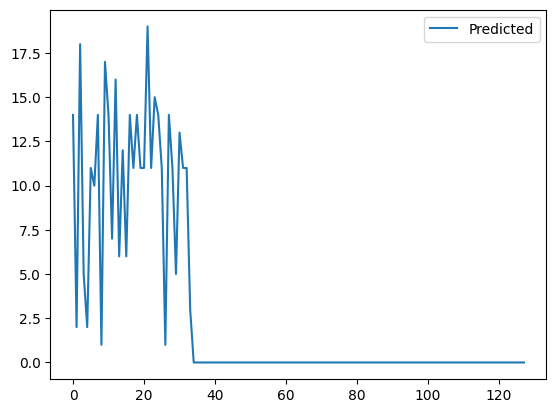

(1, 128)
For None or ~~HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH~~, predicted sequence QGHAGRIQLCQVYSPSQRQRRMRFQRLQRANRRK
Writing FASTA file:  ./output_model_B/fasta_in_0_AH_.fasta
Now run OmegaFold.... on device=cuda:0
INFO:root:Loading weights from /root/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading ./output_model_B/fasta_in_0_AH_.fasta
INFO:root:Predicting 1th chain in ./output_model_B/fasta_in_0_AH_.fasta
INFO:root:34 residues in this chain.
INFO:root:Finished prediction in 7.66 seconds.
INFO:root:Saving prediction to ./output_model_B/temp_0_AH_.pdb
INFO:root:Saved
INFO:root:Done!
Done OmegaFold
Resulting PDB file...:  ./output_model_B/temp_0_AH_.pdb
Properly named PDB file produced: ./output_model_B/~~HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH~~_0_AH__0.pdb


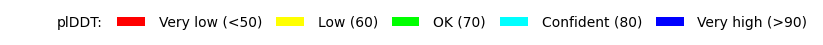

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

 INPUT:        ~~HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH~~
RESULT:       ~~~~~~~~~~~~~~~~HHHHHHHHHHHHHHHHH~
AA sequence:  QGHAGRIQLCQVYSPSQRQRRMRFQRLQRANRRK
 Error:  0.4411764705882353


In [4]:
#@title ####4-1. Generate prediction in one shot

#@markdown       ### The DSSP codes for secondary structure used here are:
#@markdown        # =====     ====
#@markdown        # Code      Structure
#@markdown        # =====     ====
#@markdown        # H         Alpha helix (4-12)
#@markdown        # B         Isolated beta-bridge residue
#@markdown        # E         Strand
#@markdown        # G         3-10 helix
#@markdown        # I         Pi helix
#@markdown        # T         Turn
#@markdown        # S         Bend
#@markdown        # ~         None
#@markdown        # =====     ====
#@markdown        input_ss_seq is the desired sequence of secondary strucutre code
#@markdown 


#@markdown Example 1: Alpha helix\


input_SS_seq = '~~HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH~~' #@param {type:"string"}
output_file_flag = '0_AH_' #@param {type:"string"}
FoldProteinOrNot = True 
## #@param ["False", "True"] {type:"raw"}

fname = sample_sequence (model_B,
   x_data=[input_SS_seq],
     flag=output_file_flag,
     cond_scales=1.,
     foldproteins=FoldProteinOrNot,
   )

#test for single case
DSSPresult,_,sequence_res=get_DSSP_result(fname) 

print (f"\033[1;32m INPUT:        {input_SS_seq}\nRESULT:       {DSSPresult}\nAA sequence:  {sequence_res}")
error=string_diff (DSSPresult, input_SS_seq)/len (input_SS_seq)
print ("\033[1;32m Error: ", error)

# for display purpose

Producing 1 samples...from image conditingig x_data  ...
['~~EEEEEETTEEEEEE~~']
Device:  cuda:0
X_cond= None
Conditioning target sequence provided via x_data ... ['~~EEEEEETTEEEEEE~~']
x_data from target sequence= tensor([[[0.2222, 0.2222, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
          0.4444, 0.4444, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
          0.2222, 0.2222, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.00

0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

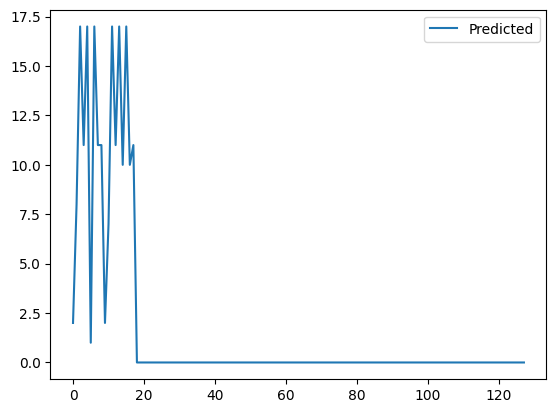

(1, 128)
For None or ~~EEEEEETTEEEEEE~~, predicted sequence GDCRCLCRRGVCRCICIR
Writing FASTA file:  ./output_model_B/fasta_in_1_BS_.fasta
Now run OmegaFold.... on device=cuda:0
INFO:root:Loading weights from /root/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading ./output_model_B/fasta_in_1_BS_.fasta
INFO:root:Predicting 1th chain in ./output_model_B/fasta_in_1_BS_.fasta
INFO:root:18 residues in this chain.
INFO:root:Finished prediction in 8.50 seconds.
INFO:root:Saving prediction to ./output_model_B/temp_1_BS_.pdb
INFO:root:Saved
INFO:root:Done!
Done OmegaFold
Resulting PDB file...:  ./output_model_B/temp_1_BS_.pdb
Properly named PDB file produced: ./output_model_B/~~EEEEEETTEEEEEE~~_1_BS__0.pdb


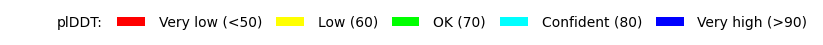

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

 INPUT:        ~~EEEEEETTEEEEEE~~
RESULT:       ~EEEEEEETTEEEEEEE~
AA sequence:  GDCRCLCRRGVCRCICIR
 Error:  0.1111111111111111


In [5]:

#@markdown Example 2: Beta sheets

input_SS_seq = '~~EEEEEETTEEEEEE~~' #@param {type:"string"}
output_file_flag = '1_BS_' #@param {type:"string"}
FoldProteinOrNot = True 
## #@param ["False", "True"] {type:"raw"}


m_cycle= 32 #cycles used in OmegaFold
fname = sample_sequence (model_B,
   x_data=[input_SS_seq],
     flag=output_file_flag,
     cond_scales=1.,
     foldproteins=FoldProteinOrNot,
     num_cycle=16, # for omegafold
   )

#test for single case
DSSPresult,_,sequence_res=get_DSSP_result(fname) 

print (f"\033[1;32m INPUT:        {input_SS_seq}\nRESULT:       {DSSPresult}\nAA sequence:  {sequence_res}")
error=string_diff (DSSPresult, input_SS_seq)/len (input_SS_seq)
print ("\033[1;32m Error: ", error)

Producing 1 samples...from image conditingig x_data  ...
['~~EEEEEETTEEEEEE~~HHHHHHHH~~']
Device:  cuda:0
X_cond= None
Conditioning target sequence provided via x_data ... ['~~EEEEEETTEEEEEE~~HHHHHHHH~~']
x_data from target sequence= tensor([[[0.2222, 0.2222, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
          0.4444, 0.4444, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
          0.2222, 0.2222, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111, 0.1111, 0.2222, 0.2222, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 

0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

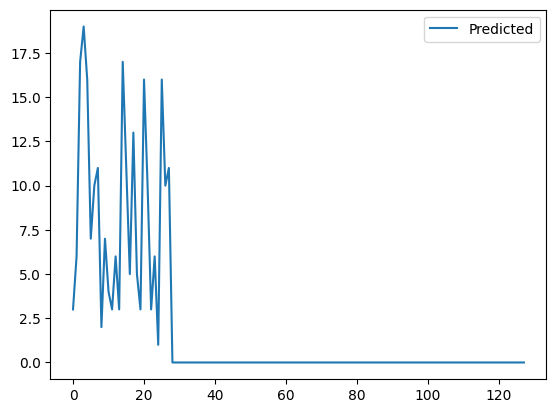

(1, 128)
For None or ~~EEEEEETTEEEEEE~~HHHHHHHH~~, predicted sequence KSCMYVIRGVEKSKCRANAKYIKSLYIR
Writing FASTA file:  ./output_model_B/fasta_in_1_BS__0.fasta
Now run OmegaFold.... on device=cuda:0
INFO:root:Loading weights from /root/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading ./output_model_B/fasta_in_1_BS__0.fasta
INFO:root:Predicting 1th chain in ./output_model_B/fasta_in_1_BS__0.fasta
INFO:root:28 residues in this chain.
INFO:root:Finished prediction in 7.80 seconds.
INFO:root:Saving prediction to ./output_model_B/temp_1_BS__0.pdb
INFO:root:Saved
INFO:root:Done!
Done OmegaFold
Resulting PDB file...:  ./output_model_B/temp_1_BS__0.pdb
Properly named PDB file produced: ./output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_1_BS__0_0.pdb


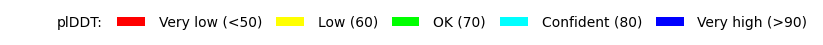

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Iteration 0: PDB file predicted:  ./output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_1_BS__0_0.pdb Error:  0.25
Cond: ~~EEEEEETTEEEEEE~~HHHHHHHH~~
Pred: ~~EEEEETTEEEEE~GGGHHHHHHHHH~
Producing 1 samples...from image conditingig x_data  ...
['~~EEEEEETTEEEEEE~~HHHHHHHH~~']
Device:  cuda:0
X_cond= None
Conditioning target sequence provided via x_data ... ['~~EEEEEETTEEEEEE~~HHHHHHHH~~']
x_data from target sequence= tensor([[[0.2222, 0.2222, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
          0.4444, 0.4444, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
          0.2222, 0.2222, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111, 0.1111, 0.2222, 0.2222, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

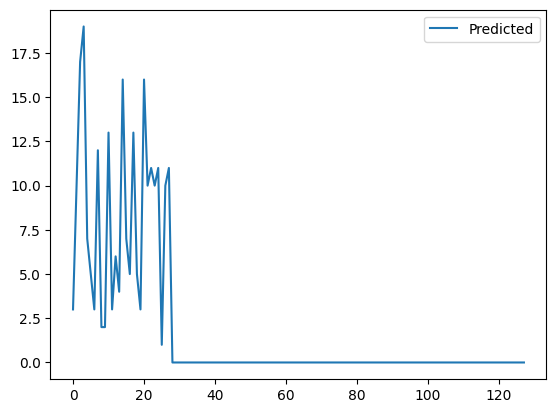

(1, 128)
For None or ~~EEEEEETTEEEEEE~~HHHHHHHH~~, predicted sequence KICMVAKPGGNKSEYVANAKYIRIRLIR
Writing FASTA file:  ./output_model_B/fasta_in_1_BS__1.fasta
Now run OmegaFold.... on device=cuda:0
INFO:root:Loading weights from /root/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading ./output_model_B/fasta_in_1_BS__1.fasta
INFO:root:Predicting 1th chain in ./output_model_B/fasta_in_1_BS__1.fasta
INFO:root:28 residues in this chain.
INFO:root:Finished prediction in 7.43 seconds.
INFO:root:Saving prediction to ./output_model_B/temp_1_BS__1.pdb
INFO:root:Saved
INFO:root:Done!
Done OmegaFold
Resulting PDB file...:  ./output_model_B/temp_1_BS__1.pdb
Properly named PDB file produced: ./output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_1_BS__1_0.pdb


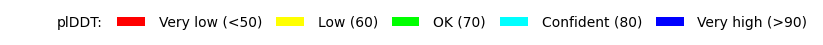

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Iteration 1: PDB file predicted:  ./output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_1_BS__1_0.pdb Error:  0.5714285714285714
Cond: ~~EEEEEETTEEEEEE~~HHHHHHHH~~
Pred: ~~~~~~~TT~~HHHHHHHHHHHHHHHH~
Producing 1 samples...from image conditingig x_data  ...
['~~EEEEEETTEEEEEE~~HHHHHHHH~~']
Device:  cuda:0
X_cond= None
Conditioning target sequence provided via x_data ... ['~~EEEEEETTEEEEEE~~HHHHHHHH~~']
x_data from target sequence= tensor([[[0.2222, 0.2222, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
          0.4444, 0.4444, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
          0.2222, 0.2222, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111, 0.1111, 0.2222, 0.2222, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

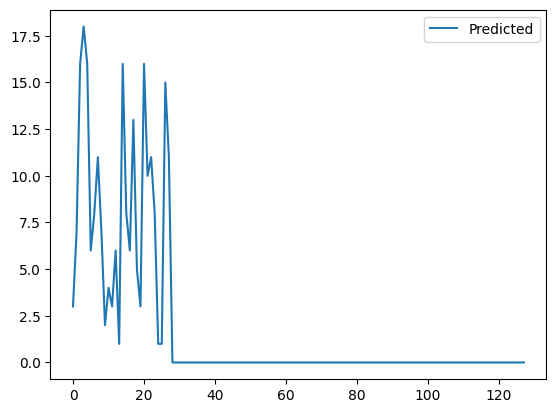

(1, 128)
For None or ~~EEEEEETTEEEEEE~~HHHHHHHH~~, predicted sequence KVYHYSDRVGEKSLYDSNAKYIRDLLFR
Writing FASTA file:  ./output_model_B/fasta_in_1_BS__2.fasta
Now run OmegaFold.... on device=cuda:0
INFO:root:Loading weights from /root/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading ./output_model_B/fasta_in_1_BS__2.fasta
INFO:root:Predicting 1th chain in ./output_model_B/fasta_in_1_BS__2.fasta
INFO:root:28 residues in this chain.
INFO:root:Finished prediction in 7.65 seconds.
INFO:root:Saving prediction to ./output_model_B/temp_1_BS__2.pdb
INFO:root:Saved
INFO:root:Done!
Done OmegaFold
Resulting PDB file...:  ./output_model_B/temp_1_BS__2.pdb
Properly named PDB file produced: ./output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_1_BS__2_0.pdb


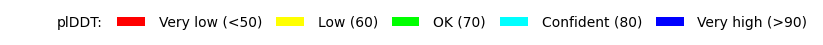

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Iteration 2: PDB file predicted:  ./output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_1_BS__2_0.pdb Error:  0.6071428571428571
Cond: ~~EEEEEETTEEEEEE~~HHHHHHHH~~
Pred: ~~~~~~~~GGGHHHHHHHHHHHHHHHT~
Producing 1 samples...from image conditingig x_data  ...
['~~EEEEEETTEEEEEE~~HHHHHHHH~~']
Device:  cuda:0
X_cond= None
Conditioning target sequence provided via x_data ... ['~~EEEEEETTEEEEEE~~HHHHHHHH~~']
x_data from target sequence= tensor([[[0.2222, 0.2222, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
          0.4444, 0.4444, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
          0.2222, 0.2222, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111, 0.1111, 0.2222, 0.2222, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

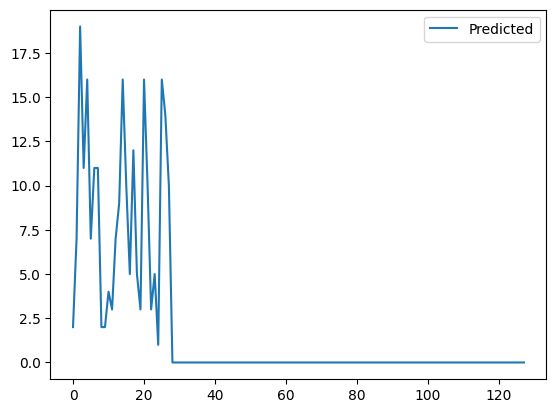

(1, 128)
For None or ~~EEEEEETTEEEEEE~~HHHHHHHH~~, predicted sequence GVMRYVRRGGEKVTYIAPAKYIKALYQI
Writing FASTA file:  ./output_model_B/fasta_in_1_BS__3.fasta
Now run OmegaFold.... on device=cuda:0
INFO:root:Loading weights from /root/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading ./output_model_B/fasta_in_1_BS__3.fasta
INFO:root:Predicting 1th chain in ./output_model_B/fasta_in_1_BS__3.fasta
INFO:root:28 residues in this chain.
INFO:root:Finished prediction in 7.72 seconds.
INFO:root:Saving prediction to ./output_model_B/temp_1_BS__3.pdb
INFO:root:Saved
INFO:root:Done!
Done OmegaFold
Resulting PDB file...:  ./output_model_B/temp_1_BS__3.pdb
Properly named PDB file produced: ./output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_1_BS__3_0.pdb


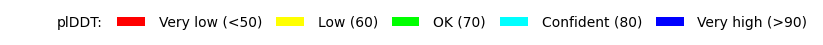

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Iteration 3: PDB file predicted:  ./output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_1_BS__3_0.pdb Error:  0.03571428571428571
Cond: ~~EEEEEETTEEEEEE~~HHHHHHHH~~
Pred: ~~EEEEEETTEEEEEE~~HHHHHHHHT~


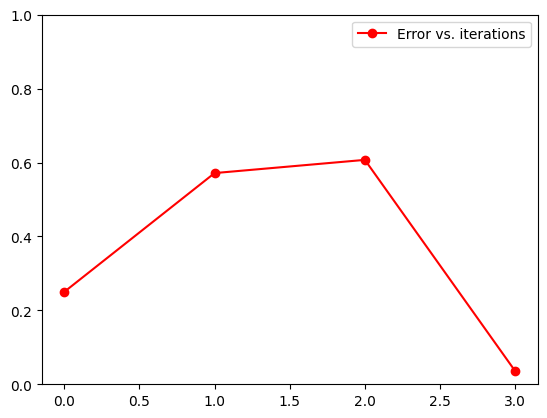

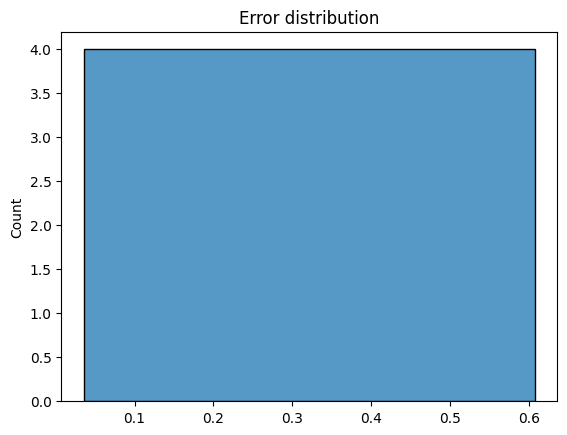

####################################################
####################################################
####################################################
FINAL RESULT at 3:  ./output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_1_BS__3_0.pdb Error:  0.03571428571428571
Seq:  GVMRYVRRGGEKVTYIAPAKYIKALYQI
Cond: ~~EEEEEETTEEEEEE~~HHHHHHHH~~
Pred: ~~EEEEEETTEEEEEE~~HHHHHHHHT~
FINAL FILE NAME at 3:  ./output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_1_BS__3_0_FINAL.pdb
####################################################
####################################################
####################################################


('./output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_1_BS__3_0.pdb',
 0.03571428571428571,
 '~~EEEEEETTEEEEEE~~HHHHHHHH~~',
 '~~EEEEEETTEEEEEE~~HHHHHHHHT~')

In [6]:
#@title ####4-2. Generate sequence via a iterative process

#@markdown Example 3: Beta sheet + alpha helix 

input_SS_seq = '~~EEEEEETTEEEEEE~~HHHHHHHH~~' #@param {type:"string"}
# output_file_flag = '2_iter_' #@param {type:"string"}
# FoldProteinOrNot = True #@param ["False", "True"] {type:"raw"}
error_threshold = 0.2 #@param {type:"slider", min:0.0, max:1, step:0.01}
max_iter = 10 #@param {type:"slider", min:0, max:100, step:1}

flag='2_iter_'

iterate_adaptive (model_B,  
                  seq=input_SS_seq,
                  flag=output_file_flag, 
                  errorthreshold=error_threshold, 
                                             
                  maxiter=max_iter)
                  
                   